
## "Analyse and predict factors related to readmission as well as other outcomes pertaining to patients with diabetes."

### The dataset 

You will be working with the [readmission data](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008). Management of hyperglycemia in hospitalized patients has a significant bearing on outcome, in terms of both morbidity and mortality. In this dataset you will need to see what the impact of various clinical practices is readmission rates.

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria:

- It is an inpatient encounter (a hospital admission).
- It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
- The length of stay was at least 1 day and at most 14 days.
- Laboratory tests were performed during the encounter.
- Medications were administered during the encounter.

The data contains attributes such as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, emergency visits in the year before the hospitalization and many others.

### The goal 

Your goal is to pre-process, analyse, visualise, and conduct unsupervised and supervised learning on this input dataset. The final outcome is a classifier that is able to predict a patient's readmission. In order to demonstrate that your solution is optimal, you will need to also include your exploratory analyses of the dataset, conduct thorough validation and parameter optimisations. You should also feel free to explore new algorithms and to use publicly available resources and solutions such as those listed on the dataset webpage as a reference (see the bottom of this page for the link).
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

You will be evaluated and given feedback on:
- Your problem-solving approach.
- Your code.
- The justifications you give for your decisions.
- The quality and performance of your solution.
- The presentation of your solution.

# 0. Submission overview
##### 1. Load libraries and import data
Load libraries, import data, check data shape, look for typos, change feature datatypes, encode features, drop features, describe dataset
###### 2. Mining and pre-processing
Extract independent encounters, encode response, impute for missing values, aggregate diagnoses, remove outliers, one-hot encode
##### 3. Exploratory data analysis
Visualise feature correlations with readmission, consider numerical feature correlations, investigate numerical feature distributions according to readmission status, look at diagnosis frequencies, modify a dataset in preparation for supervised learning
##### 4. Dimensionality reduction
Scale dataset, perform PCA, optimise a variance threshold then use it to exclude 'noisy' features, visualise changes in MCC with variance threshold, visualise explained variance by component
##### 5. Supervised learning
Discussion of scoring metric (why MCC was chosen), creation of dummy classifier, optimisation of LDA classifier, use of shrinkage on a LR classifier to identify which features to use when training a KNN classifier, model comparision and discussion
##### 6. Unsupervised learning
K-means clustering with investigation and discussion of cluster meanings, t-SNE dimensionality reduction followed by density-based clustering as a demonstration that it could be used to prepare data for supervised classification 
##### 7. Summary

# 1. Load libraries and import data

In [1]:
# Major libraries
import scipy
import bottleneck # for speeding up pandas operations
import numexpr # ditto
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Mining / EDA / dimensionality reduction
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean

# Supervised learning
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Unsupervised learning
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.colors import ListedColormap

%matplotlib inline
rng = np.random.RandomState(1)

In [5]:
print(pd.__version__)

0.18.1


As a next step, you will need to import the content of the provided `diabetic_data.csv` file, taking into account that missing values are represented by **"?"** (Hint: check the documentation for the `na_values` attribute of the `read_csv()` function). In addition, you may wish to provide an input for the `index_col` attribute and also set `low_memory=False` if you get a relevant warning. 

In [2]:
Dataset = {} # I found it was much easier to manage multiple datasets by keeping them all in a dictionary
Dataset['Raw'] = pd.read_csv('./data/diabetic_data.csv', index_col='encounter_id', na_values="?", low_memory=False)
Dataset['Raw'].shape

(101766, 49)

Perform "sanity" checks:

- Print the contents of your input data in-line or in a tabular format
- Check the dimensionality of your data (you can cross-check with the numbers on the UCl website) 
- Check and detect any format issues, missing values or anomalies. 
- Find the number of unique elements per column and the type of data that these columns contain (categorical, numeric, etc.) 
- Generate various summary statistics per column (for instance by using the `describe()` function) 

In all cases, report your findings.

In [3]:
# Print contents of dataset
Dataset['Raw'].head(5)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Get an idea of how many features are missing values, and how many values they're missing:
def percent_null(data):
    # Returns a Pandas series of what percentage of each feature of 'data' contains NaN values
    pc_null = data.apply(pd.Series.isnull).apply(lambda x: 100*round(len(x[x==True])/len(x), 4))
    return pc_null[pc_null!=0]
percent_null(Dataset['Raw'])

race                  2.23
weight               96.86
payer_code           39.56
medical_specialty    49.08
diag_1                0.02
diag_2                0.35
diag_3                1.40
dtype: float64

I checked the dataset's integrity by applying `pd.Series.value_counts()` then investigating the feature levels that appear very infrequently. In doing this, I assumed that infrequent features were more likely to contain typos / be invalid entries. I also assumed that more significant mistakes (e.g. an artefact introduced by the hospital's entry system) would become apparent during later processing.

In [5]:
feature_value_counts = [] # A list to put Series containing the number of entries for each level of a feature
for feature in Dataset['Raw'].columns:
    feature_value_counts.append(Dataset['Raw'][feature].value_counts())

In [7]:
feature_value_counts[32].ix[:] # Manually iterated through each feature to check for typos / misentries

No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64

By inspecting each entry in `feature_value_counts` I determined that no feature contained a poorly formatted entry (in the sense of being dissimilar from the format of all other entries in that feature) or a response that was nonsensical.

While doing this I noticed that a few features (e.g. `age`) were formatted inconveniently given the type of data they contain. Consequently, I label-encoded the `age` feature. Pandas also didn't discriminate between each columns' datatype, so I chose to do this manually. Finally, I dropped the `weight` and `payer_code` features because they were both missing a substantial number of values. I kept `medical_specialty` because I reasoned that the skillset of the attending doctor was relevant to the treatment they prescribed, which in turn would influence whether a patient was readmitted.

In [8]:
Dataset['Datatyped'] = Dataset['Raw'].copy() # To allow comparison between datasets before and after modification

# Remove useless features
Dataset['Datatyped'].drop(['weight', 'payer_code'], axis=1, inplace=True);

# Label-encode age feature to an integer in the center of the raw bin
Dataset['Datatyped'].age = (LabelEncoder().fit_transform(Dataset['Datatyped'].age)*10) + 5 

# Convert features to appropriate datatype - nominal and ordinate variables as categorical dtypes, interval variables as integers
cat_features = ['patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'readmitted']
num_features = Dataset['Datatyped'].columns.drop(cat_features).values

for feature in cat_features:
    Dataset['Datatyped'][feature] = Dataset['Datatyped'][feature].astype('category')

for feature in num_features:
    Dataset['Datatyped'][feature] = Dataset['Datatyped'][feature].astype('int')

Dataset['Datatyped'].dtypes # Check casting was successful

patient_nbr                 category
race                        category
gender                      category
age                            int32
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int32
medical_specialty           category
num_lab_procedures             int32
num_procedures                 int32
num_medications                int32
number_outpatient              int32
number_emergency               int32
number_inpatient               int32
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int32
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
g

In [5]:
#It should be possible to automatically datatype these using built-in pandas functions

In [7]:
print(pd.__version__)

0.18.1


Before modifying the dataset further, I took an overview of it; this provided a reference against which I could compare modfied sets later.

In [9]:
pd.set_option('max_columns',40) # To allow all columns to be seen
Dataset['Datatyped'][cat_features].describe(exclude = None) # Categorical features description

,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,diag_1,diag_2,diag_3,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,max_glu_serum,A1Cresult,readmitted
count,101766,99493,101766,101766,101766,101766,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,71518,5,3,8,26,17,72,716,748,789,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,4,4,3
top,88785891,Caucasian,Female,1,1,7,InternalMedicine,428,276,250,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,None,None,NO
freq,40,76099,54708,53990,60234,57494,14635,6862,6752,11555,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,96420,84748,54864


In [10]:
Dataset['Datatyped'][num_features].describe(exclude = None).round(1) # Numerical features description

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0
mean,66.0,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4
std,15.9,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9
min,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,55.0,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0
50%,65.0,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0
75%,75.0,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0
max,95.0,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0


In [11]:
pd.set_option('max_columns',10)

# 2. Mining and pre-processing

The first step I took in mining the data was to extract only one encounter per patient. I did this because logistic regression and linear discriminant analysis, two methods that my model depends upon, stipulate that observations must be independent. KNN will also be warped by interdependent observations, the nearest neighbor of a patient's visit may well be another visit by that same patient.

In [12]:
# Capture the first entry for each patient in a new 'Independent' entries dataset
def one_entry(data):
    unique_entry = data.iloc[0,:]
    return unique_entry

Dataset['Independent'] = Dataset['Datatyped'].copy()
Dataset['Independent'] = Dataset['Independent'].groupby('patient_nbr').apply(one_entry)

Dataset['Independent'].index = Dataset['Independent']['patient_nbr']
Dataset['Independent'].drop('patient_nbr', axis=1, inplace=True)

Dataset['Independent'].head(3)

,race,gender,age,admission_type_id,discharge_disposition_id,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
patient_nbr,,,,,,,,,,,
135,Caucasian,Female,55,2,1,...,No,No,Ch,Yes,<30
378,Caucasian,Female,55,3,1,...,No,No,No,No,NO
729,Caucasian,Female,85,1,3,...,No,No,No,Yes,NO


In [13]:
Dataset['Independent'].index.value_counts()[0:5] # Check that top value counts of patient numbers are equal to one

31203324    1
87413544    1
73579140    1
61578513    1
18479466    1
Name: patient_nbr, dtype: int64

Next I encoded the response feature to make it easier to handle (e.g. for using as a hue, computing correlation coefficients, predicting an integer response and so on).

In [14]:
Dataset['Encoded response'] = Dataset['Independent'].copy()
le_readm = LabelEncoder()
Dataset['Encoded response'].readmitted = pd.Series(le_readm.fit_transform(Dataset['Encoded response'].readmitted),
                                                      index=Dataset['Encoded response'].index)
le_readm.classes_ # 0 = <30, 1 = >30, 2 = NO

array(['<30', '>30', 'NO'], dtype=object)

In [15]:
Dataset['Encoded response'].readmitted.value_counts()

2    42985
1    22240
0     6293
Name: readmitted, dtype: int64

Following this I imputed for missing values. I chose to impute using the most frequent value in the response class of an observation, for fear of inadvertently softening distinctions between `readmission` classes. An exception to this is the `medical specialty` feature, for which I sorted the datset to cluster similar patients, then back-filled for values.

In [16]:
# Check which features contain null values
percent_null(Dataset['Encoded response'])

race                  2.72
medical_specialty    48.21
diag_1                0.02
diag_2                0.41
diag_3                1.71
dtype: float64

In [17]:
# Impute for missing values by response class
for response in Dataset['Encoded response']['readmitted'].unique():
    response_df = Dataset['Encoded response'][Dataset['Encoded response'].readmitted == response].copy()
    
    # Impute for medical specialties
    response_df = response_df.sort_values(['diag_1', 'age', 'admission_source_id']) # Clusters similar medical specialties
    response_df['medical_specialty'] = response_df['medical_specialty'].fillna(method='bfill') # backward-fill null values
    
    # Impute for race
    response_df['race'] = response_df['race'].fillna(value=response_df['race'].describe().top) # Mode vaue for race
    
    # Impute for diagnoses
    response_df['diag_1'] = response_df['diag_1'].fillna(value=response_df['diag_1'].describe().top)
    response_df['diag_2'] = response_df['diag_2'].fillna(value=response_df['diag_2'].describe().top) # Mode values
    response_df['diag_3'] = response_df['diag_3'].fillna(value=response_df['diag_3'].describe().top)
    
    # Insert imputed data back into main DataFrame
    Dataset['Encoded response'][Dataset['Encoded response'].readmitted == response] = response_df

In [18]:
# Check that imputation was successful - we're expecting percent_null() to return an empty Series
percent_null(Dataset['Encoded response'])

Series([], dtype: float64)

I was concerned about how weak each of the ICD9 diagnoses would be as one-hot encoded features - there simply weren't enough entries for most values to make an informed decision about whether they were influencing readmission. Instead, I aggregated the diagnoses under a broader class in accordance with the type of health problems each range of values relates to.

In [19]:
def ICD9_classifier(diagnoses):
    # Returns a series of strings corresponding to type of ICD9 diagnosis
    # diagnoses is a list
    gr_diagnoses = diagnoses.copy()
    icd9_dct = {
                'Infectious':(1, 139),
                'Neoplasmic':(140,239),
                'Hormonal':(240, 279),
                'Blood':(280,289),
                'Mental':(290,319),
                'Nervous':(320,359),
                'Sensory':(360,389),
                'Circulatory':(390,459),
                'Respiratory':(460,519),
                'Digestive':(520,579),
                'Genitourinary':(580,629),
                'Childbirth':(630,679),
                'Dermatological':(680,709),
                'Musculoskeletal':(710,739),
                'Congenital':(740,759),
                'Perinatal':(760,779),
                'Miscellaneous':(780,799),
                'Injury':(800,999)
               }
    for i, diagnosis in enumerate(diagnoses):
        if (str(diagnoses[i])[0] == 'E') or (str(diagnoses[i])[0] == 'V'):
            gr_diagnoses[i] = 'Accidental'
        elif (str(diagnoses[i]).lower() == 'nan'):
            gr_diagnoses[i] = 'NaN'
        else:
            for key, icd_range in icd9_dct.items():
                if (int(float(diagnoses[i])) >= icd_range[0]) and (int(float(diagnoses[i])) <= icd_range[1]):
                    gr_diagnoses[i] = key
    return gr_diagnoses

In [20]:
d1 = ICD9_classifier(Dataset['Encoded response'].diag_1.values)
d2 = ICD9_classifier(Dataset['Encoded response'].diag_2.values)
d3 = ICD9_classifier(Dataset['Encoded response'].diag_3.values)

Dataset['Aggregated diagnoses'] = Dataset['Encoded response'].copy()

Dataset['Aggregated diagnoses'].diag_1 = d1
Dataset['Aggregated diagnoses'].diag_2 = d2
Dataset['Aggregated diagnoses'].diag_3 = d3

In [21]:
Dataset['Aggregated diagnoses'].head(5)

,race,gender,age,admission_type_id,discharge_disposition_id,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
patient_nbr,,,,,,,,,,,
135,Caucasian,Female,55,2,1,...,No,No,Ch,Yes,0
378,Caucasian,Female,55,3,1,...,No,No,No,No,2
729,Caucasian,Female,85,1,3,...,No,No,No,Yes,2
774,Caucasian,Female,85,1,1,...,No,No,Ch,Yes,2
927,AfricanAmerican,Female,35,1,1,...,No,No,No,Yes,2


I then removed outliers. I classified outliers according to a specified distance from the first and third quartiles. Many of the features have skewed distributions (as we shall see in EDA) which would warp mean estimates of central tendency and estimates of standard deviation.

In [22]:
Dataset['Aggregated diagnoses'].shape # Before removing outliers

(71518, 46)

In [23]:
Dataset['Trimmed'] = Dataset['Aggregated diagnoses'].copy()
Dataset['Trimmed'].describe().ix[['min', 'max'],:]

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
min,5.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0
max,95.0,8.0,28.0,25.0,14.0,...,42.0,42.0,12.0,16.0,2.0


In [24]:
# Remove outliers by class
for response in Dataset['Trimmed'].readmitted.unique(): # For each readmission response
    response_df = Dataset['Trimmed'][Dataset['Trimmed'].readmitted==response] # For all samples that meet the readmission criteria
    for column in response_df[num_features].columns: # Iterate through each feature of the sample
        Q1 = response_df[column].quantile(0.25)
        Q3 = response_df[column].quantile(0.75)
        IQR = Q3-Q1
        if IQR > 0: # And remove features that are outside of Q1 - 1.5IQR or Q3 + 1.5IQR
            response_df = response_df[(response_df[column] > Q1-(1.5*IQR)) & (response_df[column] < Q3+(1.5*IQR))]
            Dataset['Trimmed'] = Dataset['Trimmed'].drop(Dataset['Trimmed'][Dataset['Trimmed'].readmitted==response].index, axis=0)
            Dataset['Trimmed'] = Dataset['Trimmed'].append(response_df)

In [25]:
Dataset['Trimmed'].describe().ix[['min', 'max'],:]

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
min,35.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0
max,95.0,8.0,28.0,25.0,14.0,...,42.0,42.0,12.0,14.0,2.0


In [26]:
Dataset['Trimmed'].shape # After outlier-removal

(60344, 46)

Next I one-hot encoded categorical features. Originally, I had terrible problems with my laptop crashing while performing this operation - this was because of the sheer number of features needed to encode all of the ICD9 diagonoses. By simplifying that feature, I made the dataset computationally manageable.

In [27]:
# Separate response from features
y = Dataset['Trimmed'].readmitted
X = Dataset['Trimmed'][(Dataset['Trimmed'].columns).drop('readmitted')]

cat_features.remove('readmitted'); cat_features.remove('patient_nbr')

X_ohe = pd.get_dummies(X, columns=cat_features)
Dataset['Large OHE'] = X_ohe.join(y) # One-hot encoded dataset with many dimensions
Dataset['Large OHE'].shape

(60344, 268)

# 3. Exploratory Data Analysis

Something I realised while dealing with this dataset is that my analysis could be afflicted by the curse of dimensionality. This mythical-sounding phenomenon basically means that a classifier will have reduced predictive power as the number of features its fitting to increases, because the data becomes exponentially more sparse as the space gains dimensions. Moreover, we can be less sure of any estimates we make because each additional dimension requires the same amount of data to describe variation in a greater number of directions.

Additionally, the computation time for any classifier trained would scale with the number of features, and I didn't fancy using my laptop as a lapwarmer for too many hours.

With these considerations in mind, I used EDA to inform construction of a dataset I would use for training supervised classifiers later.

But EDA - in my exploratory analysis of this dataset, I looked at relationships between features, and between features and the response. I made some observations about how feature distributions differ between patients that were and were not readmitted, and emphasised that there's some collinearity in the dataset.

In [28]:
correlations_df = Dataset['Large OHE'].corr()

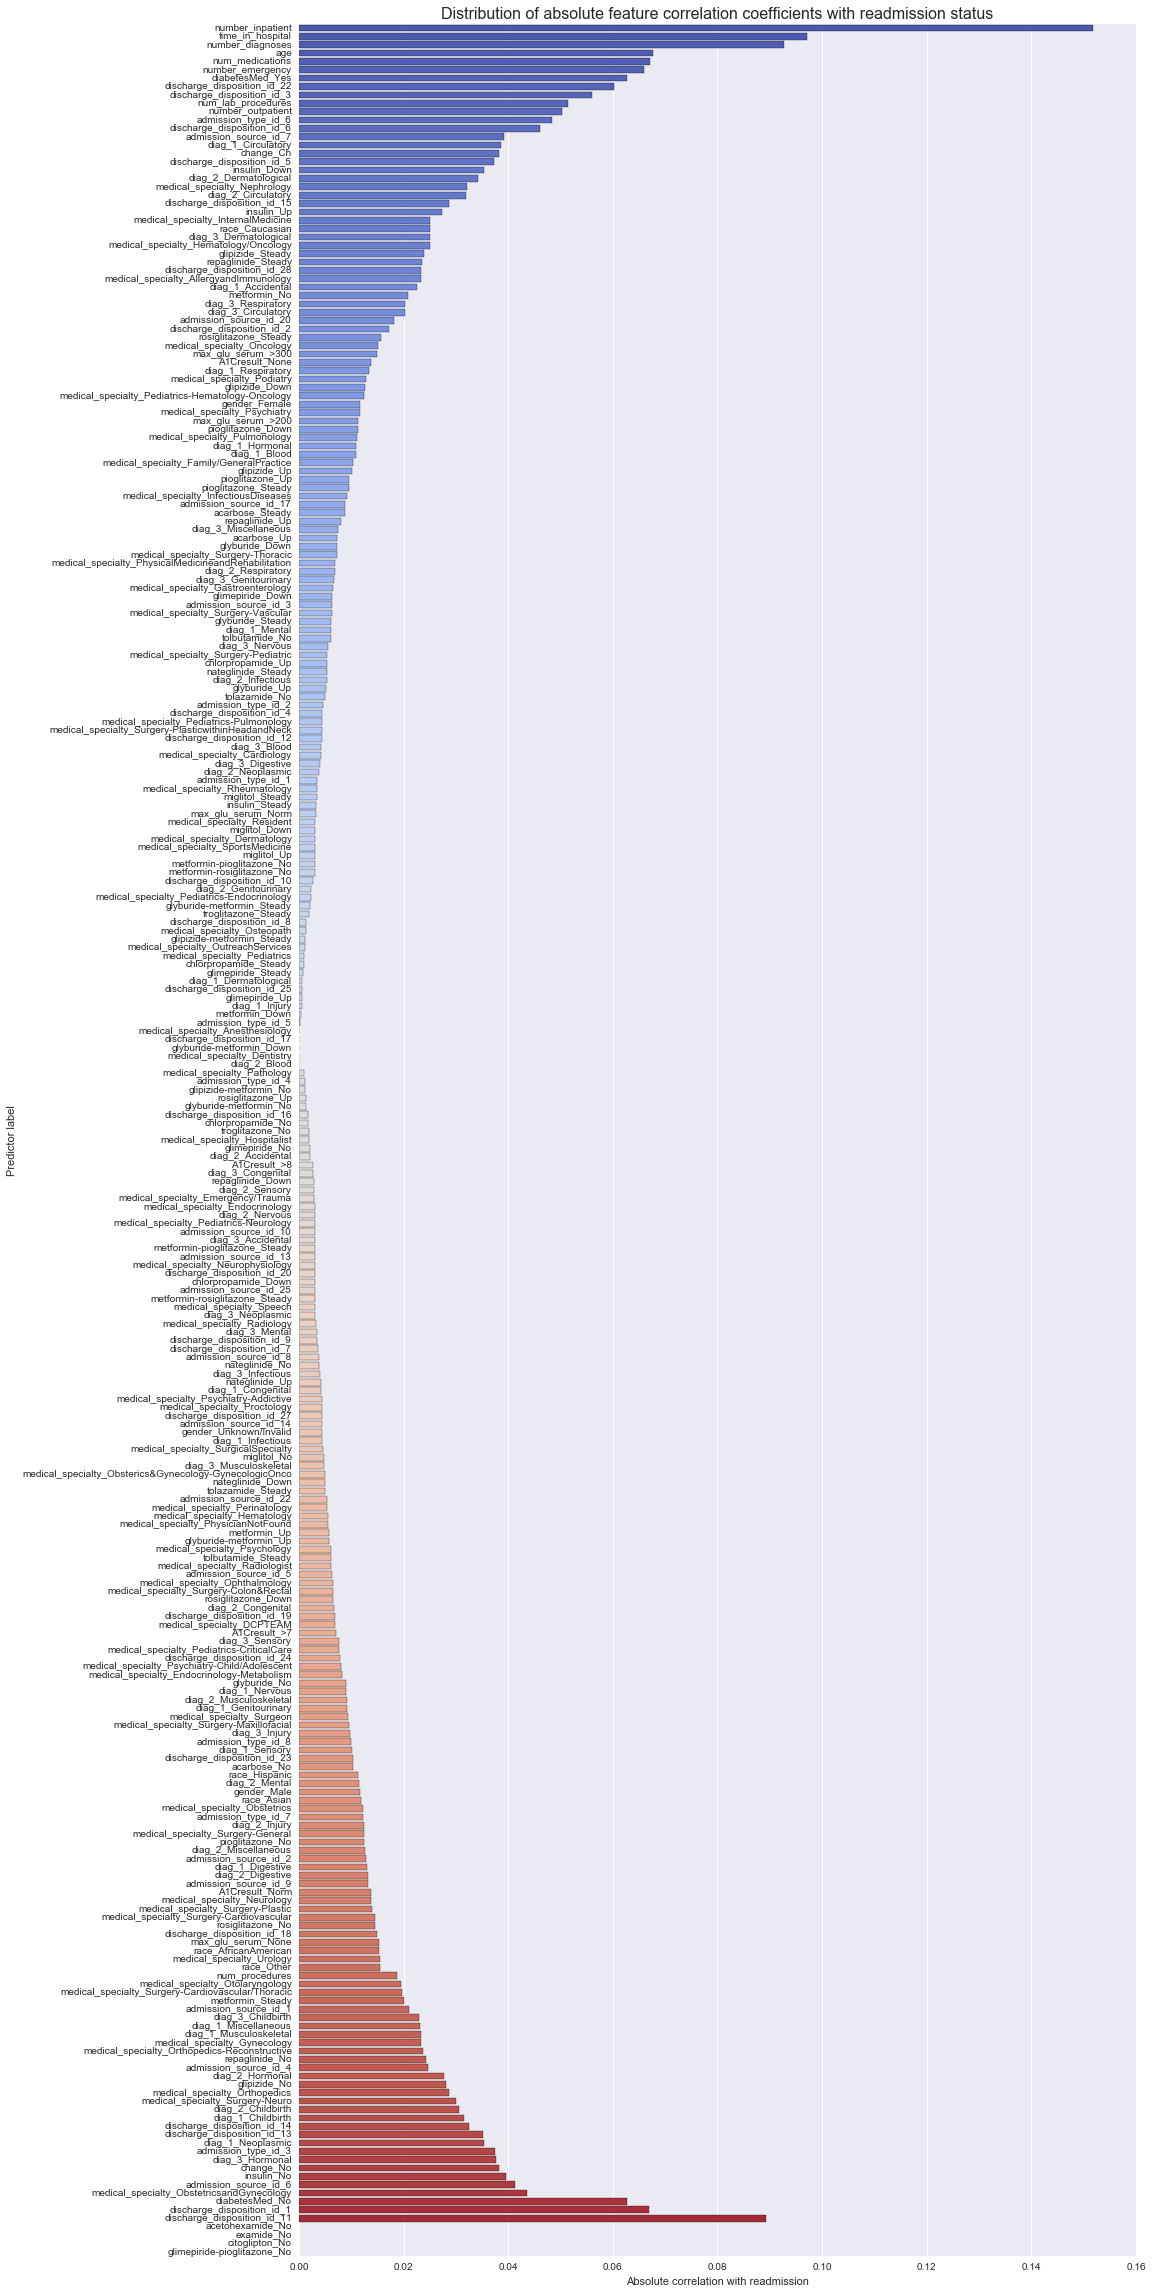

In [29]:
plt.figure(figsize=(15,40))
abs_corr_coef = abs(correlations_df.ix[correlations_df.columns.drop('readmitted'),'readmitted'].sort_values())
sns.barplot(abs_corr_coef, abs_corr_coef.index, orient='h', palette=sns.color_palette('coolwarm', len(abs_corr_coef)))
plt.ylabel('Predictor label'); plt.xlabel('Absolute correlation with readmission');
plt.title('Distribution of absolute feature correlation coefficients with readmission status', size=16);

Note that the NaN values here correspond to features with only one level - there can't be a correlation between a constant and a variable! 

One of the most informative aspects of the correlation coefficients was that they were all very small ($\rho < 0.1$), which suggested to me it would be difficult to isolate factors that influence the reponse (as opposed to noisy factors). This chart also made it immediately apparent which features would probably prove most useful in discriminating between response classes - `age`, `number_inpatient`, `number_diagnoses`, and the a patients' usage of diabetes medication.

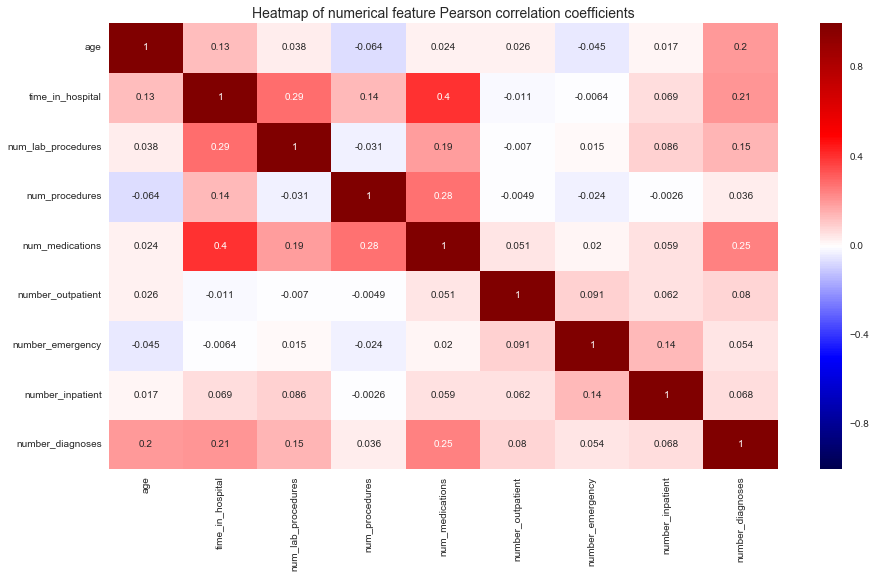

In [30]:
num_features_corr = Dataset['Large OHE'][num_features].corr()
plt.figure(figsize=(15,8))
sns.heatmap(num_features_corr, annot=True, cmap='seismic')
plt.xticks(rotation=90); plt.title('Heatmap of numerical feature Pearson correlation coefficients', size=14);

This heatmap showed that there was some considerable (in the context of this dataset) collinearity between features, which suggested to me that applying a dimensionality reduction technique was a good idea. Collinear features are undesirable because they make estimates of a parametric model's coefficients less accurate.

Before moving on to dimensionality reduction, I demonstrated some differences between patients from each readmission class, and discuss possible explanations for these differences. I focused on examining the features that were strongly correlated (in this context) with readmission. 

A brief reminder! <br/>
`readmitted = 0` -> readmitted within 30 days <br/>
`readmitted = 1` -> readmitted in more than 30 days <br/>
`readmitted = 2` -> Not readmitted / no record of readmission

#### 3.1. *Influence of number of inpatient  encounters on readmission class*

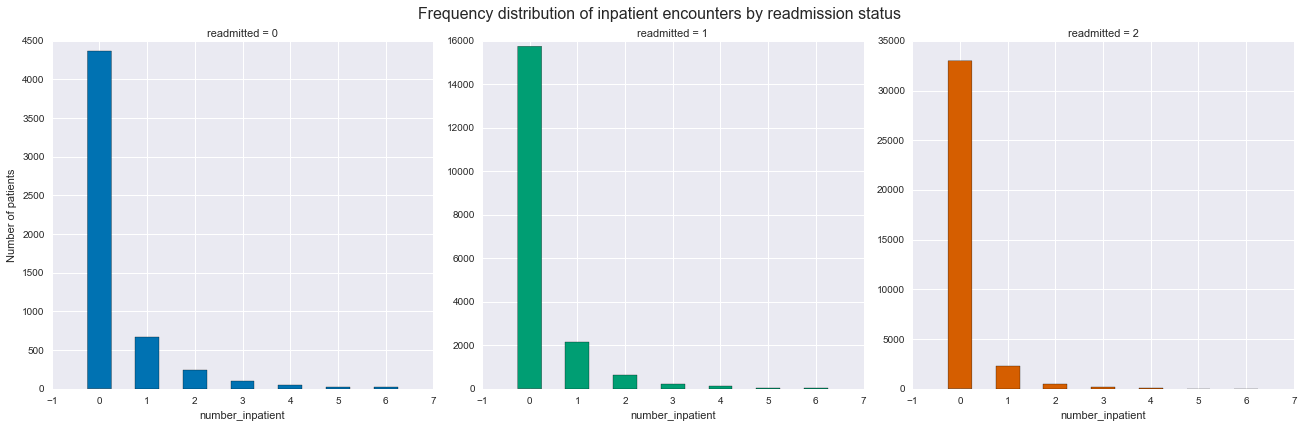

In [31]:
g = sns.FacetGrid(Dataset['Trimmed'], col="readmitted", subplot_kws={'alpha':1}, size=6,
                  sharey=False, palette='colorblind',hue='readmitted')  
g.map(sns.distplot, "number_inpatient", kde=False, hist_kws={'width':0.5, 'alpha':1, 'align':'mid'},
      bins=np.arange(-0.25,7.25,1));
g.axes[0][0].set_ylabel('Number of patients')
plt.suptitle('Frequency distribution of inpatient encounters by readmission status', size=16);
plt.subplots_adjust(top=0.9);

These distributions appeared outwardly to be very similar - most patients typically hadn't visited previously as an inpatient, and a negligible number had more than 4 or 5 visits in their record. Note however, that a greater proportion of patients that were readmitted had at least *some* history of readmission - all bins greater than 0 are more heavily populated in the `readmitted = True` chart than in its `False` counterpart.

Additionally, the `number_inpatient` feature wasn't strongly correlated with the other features that were covariant with readmission, so I expected it to feature prominently in the supervised fits later.

#### 3.2. *Influence of length of visit on readmission*

Contradistinctively, `time_in_hospital`, the feature with the second-strongest correlation with `readmission` was strongly correlated with other features. Let's see how patients of different readmission classes were distributed within this feature.

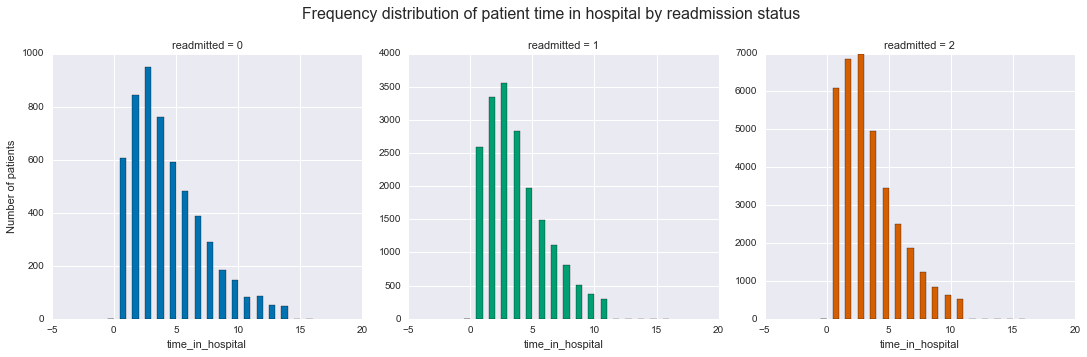

In [32]:
g = sns.FacetGrid(Dataset['Trimmed'], col="readmitted", subplot_kws={'alpha':1}, size=5, sharey=False, palette='colorblind',
                  hue='readmitted')  
g.map(sns.distplot, "time_in_hospital", kde=False, hist_kws={'width':0.5, 'alpha':1}, bins=np.arange(-0.5,17));
g.axes[0][0].set_ylabel('Number of patients')
plt.suptitle('Frequency distribution of patient time in hospital by readmission status', size=16);
plt.subplots_adjust(top=0.85);

The difference here is quite immediately clear - patients that were readmitted tended to spend longer in hospital. As can be seen from the boxplot below, the difference in median time spent in hospital between the two readmission classes was about a day.

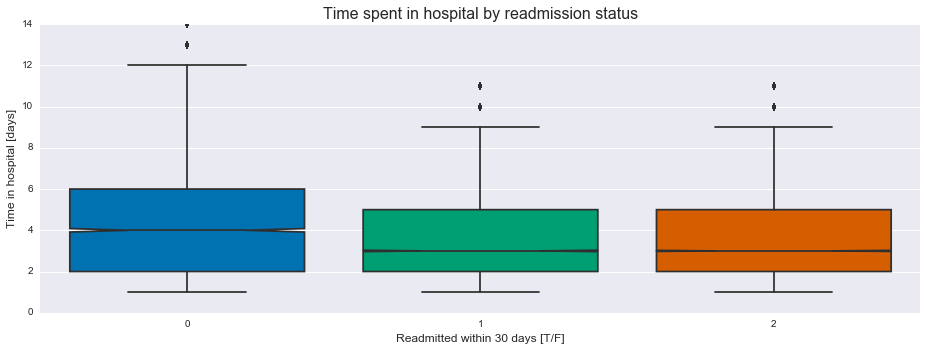

In [33]:
f = plt.figure(figsize=(13,5))
sns.boxplot(x='readmitted', y='time_in_hospital',
           data=Dataset['Trimmed'], palette='colorblind', saturation=1, orient='v', notch=True)
plt.ylabel('Time in hospital [days]', size=12); plt.xlabel('Readmitted within 30 days [T/F]', size=12);
plt.title('Time spent in hospital by readmission status', size=16)
plt.tight_layout()

Continuing our rampage through the greatest hits of the features that readmission class correlated with, we pause brielfly to explain the absence of `number_medications`. In short, this feature was so strongly correlated with `time_in_hospital` that I didn't see the value in presenting it in addition to the above. Safe to say, the trend is similar - readmitted patients tended to have a greater number of prescriptions. A possible reason that these features are strongly correlated is that people who require a greater number of medications tend to be more unwell, and correspondingly require more time in hospital (in spite of their medications). The arrow of inference could equally as well run in the other direction. I am stating the obvious somewhat, but it's important to be aware of this relationship as correlated predictors can make some classification algorithms unstable (e.g. logistic regression). That potentially sicker patients are more likely to be readmitted is unsurprising, but it's encouraging that specific metrics, such as those above, could be used to monitor the efficacy of new treatments introduced for especially unwell diabetics.

#### 3.3. *Influence of age on readmission status*

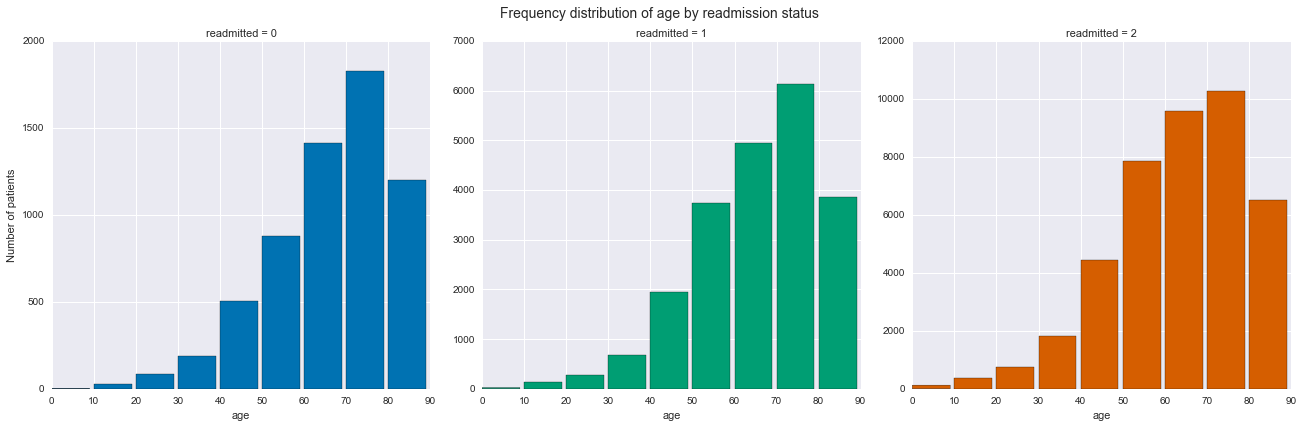

In [34]:
g = sns.FacetGrid(Dataset['Aggregated diagnoses'], col="readmitted", subplot_kws={'alpha':1}, size=6, sharey=False,
                  palette='colorblind',hue='readmitted')  
g.map(sns.distplot, "age", kde=False, hist_kws={'width':9, 'alpha':1}, bins=np.arange(0,100,10));
g.axes[0][0].set_ylabel('Number of patients')
plt.suptitle('Frequency distribution of age by readmission status', size=14);
plt.subplots_adjust(top=0.9);

The steeper distribution on the right indicated both a markedly higher mean age for readmitted patients, as well as a smaller spread of ages about that mean age. A patient that has been readmitted was likely to be older than a patient that was not readmitted. This statement was reflected by the mean age of a patient in either class, as illustrated in the boxplot below.

A broader point to mention here is the under-representation of young people in the dataset - given that type 2 diabetes is about nine times more prevalent than type 1 diabetes, and that type 2 diabetes typically affects the middle-aged and elderly, this observation bears explanation.

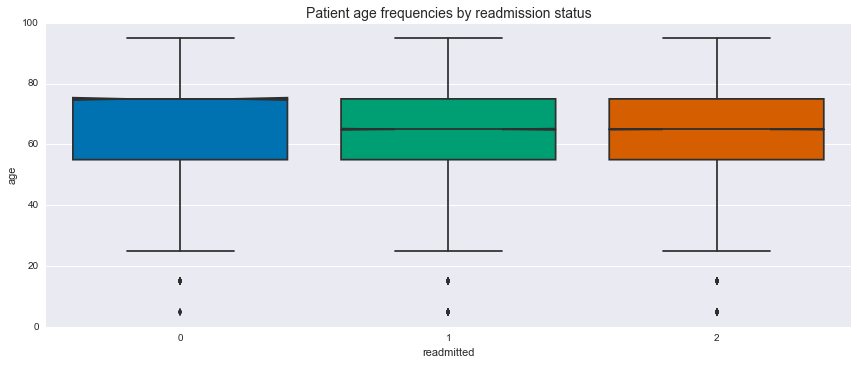

In [35]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='readmitted', y='age', data=Dataset['Encoded response'], palette='colorblind', notch=True, saturation=1)
plt.tight_layout()
plt.title('Patient age frequencies by readmission status', size=14);

One of the misleading things abou this boplot is that it could be inferred that the distributions of patient ages were identical for patients that weren't readmitted or were readmitted in more than 30 days. Studying the distributions using a histogram shows that this is not true - if anything, classes 0 and 1 were more similar.

In [36]:
Dataset['Large OHE']['age'][Dataset['Trimmed']['readmitted']==0].mean()

69.08867890241686

In [37]:
Dataset['Large OHE']['age'][Dataset['Trimmed']['readmitted']==1].mean()

67.83199407908648

In [38]:
Dataset['Large OHE']['age'][Dataset['Trimmed']['readmitted']==2].mean()

66.21447459986082

#### 3.4. *Which diagnosis was most common among the patients?*

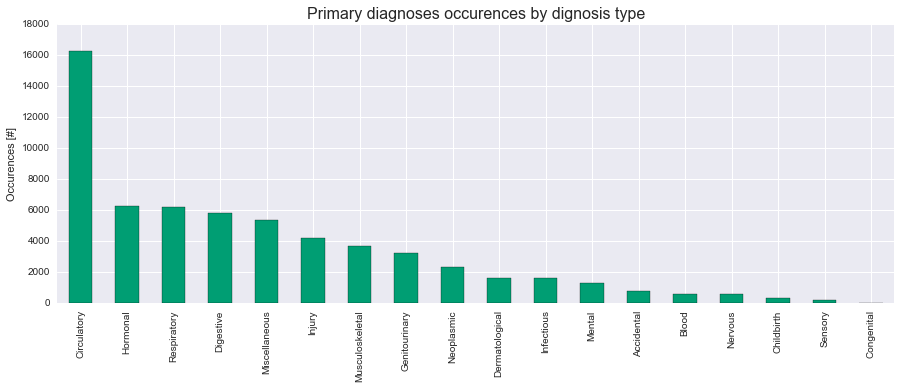

In [39]:
plt.figure(figsize=(15,5))
Dataset['Trimmed'].diag_1.value_counts().plot(color=sns.color_palette('colorblind')[1], kind='bar', rot=90);
plt.title('Primary diagnoses occurences by dignosis type', size=16);
plt.ylabel('Occurences [#]');

We can see that circulatory diseases have a substantial lead. Given that cardiovascular disease and kidney disease are more prevalent among diabetics [http://tinyurl.com/hxp6afc], and that this dataset was built out of records for which some form of diabetes was entered as a diagnosis, it seems reasonable that these would be among the most common primary diagnoses. 

There is the possibility that what's shown above is representative of the diagnosis frequency for *all* patients in these hospitals between 1998 and 2008, but a quick glance of [http://www.hcup-us.ahrq.gov/reports/statbriefs/sb148.pdf] suggests that this isn't the case, purely on the basis of how under-represented liveborn cases were. The top 7 principal diagnoses in US hospitals for 2010 were:
1. Liveborn (childbirth) [126 per 10 000 pop.]
2. Pneumonia (respiratory) [36 per 10 000 pop.], T1 is a risk factor
3. Osteoarthritis (musculoskeletal) [31 per 10 000 pop.]
4. Congestive heart failure (circulatory) [31 per 10 000 pop.], T2 is a risk factor
5. Septicemia (infectious) [30 per 10 000 pop.], T1 is a risk factor (T2 could be considered a minor risk factor)
6. Mood disorders (mental) [29 per 10 000 pop.]
7. Cardiac dysrhythmia (circulatory) [25 per 10 000 pop.], T2 is a risk factor

Given that about 9% of the US population had diabetes in 2010 [http://www.diabetes.org/diabetes-basics/statistics/], it's quite likely that this ranking can be related the to the relative frequency of diagnoses among diabetics in this dataset. Constructing such a relationship would be a quite an endeavor and a tangent however, so let's remain on-task.

#### 3.5. *Review of EDA outcomes and consequent modifications of supervised learning dataset(s)*
One of the decisions that EDA informed was how to handle observations with `readmission > 30 days`. My initial analysis was performed using a dataset in which `>30 days` and `NO` were merged, based on the fact that their centroids were slightly closer together than '>30 days' and '<30 days' - I realise now that this was misguided. For the most important features - those that correlated strongly with readmission - patients that were readmitted in `>30 days` tended to be more similar to patients that were readmitted in `<30 days`. I saw this while exploring the data. 

Interestingly, a paper associated with this dataset chose to do what I had originally done; I would be curious to hear whether their reasoning was informed by the data or by common sense. Intuitively I would have expected patients that were readmitted in `>30 days` in a dataset spanning ten years to have little in common with 'severe' (`<30 days`) cases. However, `number_inpatient`, `age`, and `time_in_hosptial` were more similar between `<30 days` and `>30 days` than `>30 days` and `NO`, suggesting that this intuition was false.

Overall, the 'distance' between the response class centroids were similar - this was why I chose to merge the responses according to the most significant features, rather than according to absolute distance.

In [42]:
# Response class centroid pairwise distances
Dataset['Scaled'] = pd.DataFrame(scale(Dataset['Large OHE']), index=Dataset['Large OHE'].index, columns=Dataset['Large OHE'].columns)

centroid_0 = Dataset['Scaled'].loc[Dataset['Large OHE'].readmitted == 0, :].mean()
centroid_1 = Dataset['Scaled'].loc[Dataset['Large OHE'].readmitted == 1, :].mean()
centroid_2 = Dataset['Scaled'].loc[Dataset['Large OHE'].readmitted == 2, :].mean();

euclidean(centroid_1, centroid_2) # '>30 days' and 'No' were slightly closer

1.704878525260768

In [43]:
euclidean(centroid_0, centroid_1) # but EDA suggested '<30 days' and '>30 days' were closer for the most important features

1.7225849687568773

It (almost) goes without saying that the responses were imbalanced; this was a cause for consternation, and it was serendipitous that they were somewhat rebalanced by merging `readmitted = {<30, >30}`. To have a clearer conscience, I chose the optimisation metric and class-weighting hyperparameters to reflect this fact.

In [47]:
# 3 different datasets to test classifier performances on
Dataset['Large supervised'] = Dataset['Large OHE'].copy() # Includes all features
Dataset['Filtered supervised'] = Dataset['Large OHE'].copy() # Will undergo filtering
Dataset['Dense supervised'] = Dataset['Trimmed'][np.concatenate((num_features, ['readmitted']), 0)] # Only includes num. features

In [48]:
 # Create a binary response - readmitted = {True, False}, removed > 30 days
for prefix in ['Large', 'Filtered', 'Dense']:
    set_label = prefix + ' supervised'
    Dataset[set_label].loc[Dataset[set_label].readmitted == 0, 'readmitted'] = 1 # {0, 1} -> {1}
    Dataset[set_label].loc[Dataset[set_label].readmitted == 2, 'readmitted'] = 0 # {2} -> {0}

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The last step in preparing data for supervised learning was to create three pairs of training and testing sets.

In [49]:
# Split filtered data into predictors and response
X = Dataset['Filtered supervised'].loc[:, Dataset['Filtered supervised'].columns.drop('readmitted')]
y = Dataset['Filtered supervised'].loc[:, 'readmitted']

In [50]:
# One-hot encode predictors
ohe_features = pd.get_dummies(X[X.columns.drop(num_features)])
X = X[num_features].join(ohe_features)

In [51]:
# Split all datasets into training and testing subsets
Training = {}; Testing = {};

(Training['O_Filtered'], Testing['O_Filtered'],
Training['R_Filtered'], Testing['R_Filtered']) = train_test_split(X, y, random_state=0)

(Training['O_Large'], Testing['O_Large'],
 Training['R_Large'], Testing['R_Large'] ) = train_test_split(Dataset['Large supervised'].drop('readmitted',axis=1),
                                                                Dataset['Large supervised'].readmitted, random_state=0)

(Training['O_Dense'], Testing['O_Dense'],
 Training['R_Dense'], Testing['R_Dense'] ) = train_test_split(Dataset['Dense supervised'].drop('readmitted',axis=1),
                                                                Dataset['Dense supervised'].readmitted, random_state=0)

# 4. Dimensionality reduction

EDA exposed the fact that some of the features most strongly correlated with readmission were collinear. Principal component analysis transforms the coordinate system so that all features are orthogonal and axes are ranked in order of how much variance they account for. Collinear features inflate the errors on estimates of regression coefficients, although this shouldn't be a problem here as we have a large dataset. Instead, principal component analysis is useful as a means of filtering out noise from the dataset. If noise is normally distributed for all features, then the high-dimensional position for a datapoint of given features will also be normally distributed about some nominal position. Consequently, principal components in direction of high variance will have a higher signal to noise ratio than those in directions of low variance. It is this line of reasoning that I exploited to filter noise from the dataset.

In [52]:
opt_metric = metrics.make_scorer(metrics.matthews_corrcoef) # Will be explained later

Scaling had to be performed on all three datasets because it's an assumption of linear discriminant analysis, is necessary for PCA to produce a relevant result, and attributes even weight to all features under KNN classification. It's not necessary for logistic regression.

In [53]:
pca = PCA()
ss = StandardScaler()

for set_label in ['Large', 'Filtered', 'Dense']:
    obs_label = 'O_'+set_label
    Training[obs_label] = pd.DataFrame(ss.fit_transform(Training[obs_label]), index=Training[obs_label].index,
                                            columns=Training[obs_label].columns)
    Testing[obs_label] = pd.DataFrame(ss.fit_transform(Testing[obs_label]), index=Testing[obs_label].index,
                                         columns=Testing[obs_label].columns)

pc_labels = ['PC_'+str(i) for i in range(0,len(Training['O_Filtered'].columns))]
Training['O_Filtered'] = pd.DataFrame(pca.fit_transform(Training['O_Filtered']),
                                      index=Training['O_Filtered'].index, columns=pc_labels)
Testing['O_Filtered'] = pd.DataFrame(pca.transform(Testing['O_Filtered']), index=Testing['O_Filtered'].index,
                                     columns=pc_labels)

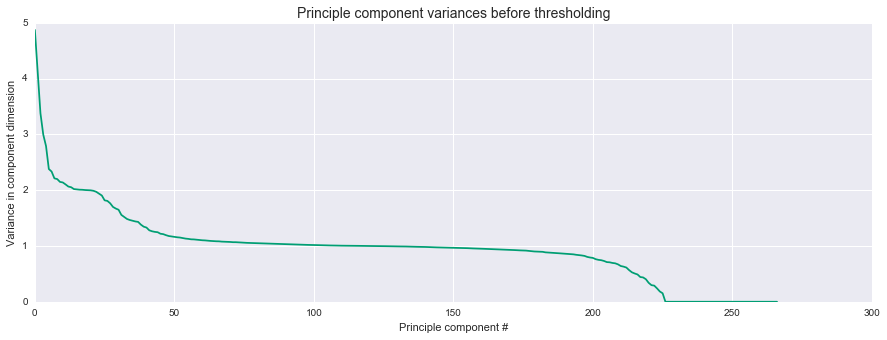

In [54]:
# Examine initial distribution of principal component variances
vt = VarianceThreshold()
vt.fit(Training['O_Filtered'])
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,len(Training['O_Filtered'].columns)),pd.Series(vt.variances_), color=sns.color_palette('colorblind')[1])
plt.xlabel('Principle component #'); plt.ylabel('Variance in component dimension');
plt.title('Principle component variances before thresholding', size=14);

In [55]:
# Create a function to examine how a classifier's behaviour changes with the number of components
def optimise_variance_threshold(classifier, X, y, max_variance, increment, scoring_metric, min_variance=0):
    scores = []
    for current_threshold in np.arange(min_variance, max_variance, increment):
        vt_0 = VarianceThreshold(threshold=current_threshold)
        X_vt = pd.DataFrame(vt_0.fit_transform(X), index=X.index)
        variance_score = cross_val_score(classifier, X_vt, y, scoring=scoring_metric)
        scores.append(variance_score.mean())
    return scores

By optimising a LDA classifier against datasets containing all PCs with at least a certain variance, I hoped to remove 'noisy' components that didn't contribute anything to the classifier's form. LDA chooses a direction that maximizes class separation, so I reasoned that a LDA classifier's Matthews correlation coefficient score would indicate how that direction is being computed - if it didn't change, then the data in the components removed did not contribute to distinguishing the classes, and was therefore noise.

Short warning - operations from here on out are going to take a little longer; I invite you to take a short break while some of them are running!

In [56]:
variance_mcc_scores = optimise_variance_threshold(LinearDiscriminantAnalysis(), Training['O_Filtered'],
                                                  Training['R_Filtered'], scoring_metric=opt_metric, max_variance=3,
                                                  increment=0.05, min_variance=0.01)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anacond

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


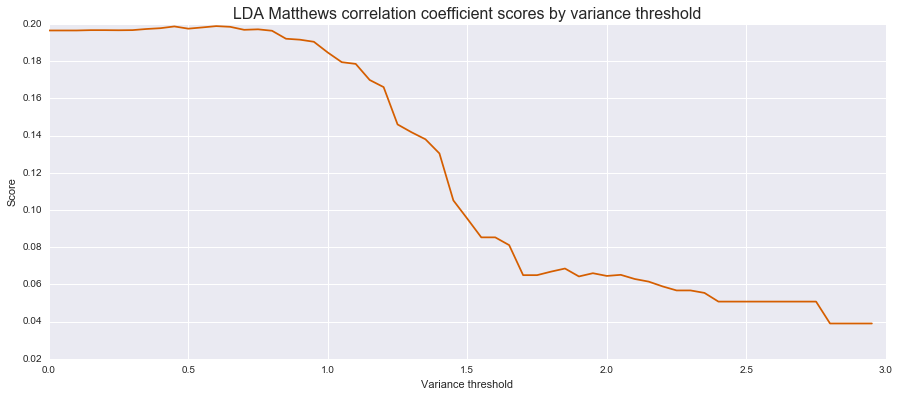

In [57]:
plt.figure(figsize=(15,6));
plt.plot(np.arange(0, 3, 0.05), variance_mcc_scores, color=sns.color_palette('colorblind')[2])
plt.xlabel('Variance threshold'); plt.ylabel('Score'); plt.title('LDA Matthews correlation coefficient scores by variance threshold', size=16);
plt.legend()
plt.show()

We can see that the classifier is unaffected up until components with a variance greater than 0.6 are removed, where its score peters downward. This indicates the axis chosen according to linear discriminant analysis isn't being affected by the principal components with a variance less than about 0.6. Consequently, I thought it was reasonable to remove them.

In [58]:
# Remove noisy components
vt_0 = VarianceThreshold(threshold=0.6)
Training['O_Filtered'] = pd.DataFrame(vt_0.fit_transform(Training['O_Filtered']), index=Training['O_Filtered'].index)
Testing['O_Filtered'] = pd.DataFrame(vt_0.transform(Testing['O_Filtered']), index=Testing['O_Filtered'].index)

column_labels = ['PC_'+str(i) for i in range(0, len(Training['O_Filtered'].columns))]
Training['O_Filtered'].columns = column_labels
Testing['O_Filtered'].columns = column_labels

In [59]:
Training['O_Filtered'].shape

(45258, 213)

# 5. Supervised learning

Before going about selecting and optimising a supervised learning algorithm, I thought about what metric to optimise on. I toyed with the idea of defining a loss function that reflected the relative costs of readmission versus whatever would happen if a patient was readmitted, but eventually dropped it because it felt artificial in the absence of more information about how a hospital would treat a patient that was predicted to be readmission risk. I knew that accuracy would be a poor measure of performance, because the responses were imbalanced. In pursuit of a suitable metric, I cycled through precision and various f-beta scores, before eventually settling on the Matthews correlation coefficient. This alone was insufficient to assess ultimate classifier performance however, so I supplemented it with a confusion matrix. The Matthews correlation coefficient is defined as
$$
MCC = \frac{TP\times TN - FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
$$
and quantifies the correlation between the observed and predicted classes.

It should also be noted that I didn't rebalance the classes manually, instead nominating to use `LogisticRegression()`'s `class_weight` argument and `LinearDiscriminantAnalysis()`'s `priors` argument to balance the classifiers produced.

I used a null classifier that made prediction based on class prior probabilities as a baseline against which to measure the performance of other classifiers.

#### 5.1. *Optimisation of a linear discriminant classifier on the filtered dataset* 

In [103]:
# Null classifier against which to compare all others
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(Training['O_Filtered'], Training['R_Filtered'])
dummy_predictions = cross_val_predict(dummy_classifier, Training['O_Filtered'], 
                                      Training['R_Filtered'], cv=5)
null_classifier_score = cross_val_score(dummy_classifier, Training['O_Filtered'],
                                        Training['R_Filtered'], scoring=opt_metric, cv=5).mean()
null_classifier_score

-9.1116001184091128e-05

I compared the suitability of the datasets ('Large' - all features, 'Filtered' - variance thresholded principal components, 'Dense' - numerical features only) for training by looking at how well an unoptimised LDA classifier scored with each of them.

In [61]:
# Unoptimised classifiers - effectively a feature set comparison
LDA = {}
LDA_scores = {}
for set_label in ['Large', 'Filtered', 'Dense']:
    LDA[set_label] = LinearDiscriminantAnalysis()
    LDA_scores[set_label] = cross_val_score(LDA[set_label], X=Training['O_'+set_label],
                                            y=Training['R_'+set_label], cv=5, scoring=opt_metric)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [64]:
LDA_scores

{'Dense': array([ 0.14446142,  0.12764539,  0.15038088,  0.14475924,  0.14539958]),
 'Filtered': array([ 0.20222645,  0.19041834,  0.21229487,  0.19740976,  0.20282226]),
 'Large': array([ 0.20370384,  0.19008205,  0.15900295,  0.1507829 ,  0.17473102])}

It was apparent that the `Filtered` dataset produced both higher-scoring and more stable classifiers, which meant that the variance thresholding was worthwhile. Having shown that this dataset performed well, I optimised a LDA classifier on it by tuning its `priors` and `solver` hyperparameters.

In [65]:
prior_values = []
for i in np.arange(0, 1, 0.01):
    prior_values.append([i, 1-i])

lda_gridCV = GridSearchCV(LinearDiscriminantAnalysis(),
                          param_grid = {'priors':prior_values,
                                        'solver':['svd', 'lsqr'], # NumPy wasn't able to solve the eigenvector problem for this dataset?
                                        },
                          scoring=opt_metric)

In [66]:
lda_gridCV.fit(Training['O_Filtered'], Training['R_Filtered']);

In [67]:
svd_scores = []; lsqr_scores = [];

for classifier_info in lda_gridCV.grid_scores_:
    if classifier_info[0]['solver'] == 'svd':
        svd_scores.append(classifier_info[1])
    if classifier_info[0]['solver'] == 'lsqr':
        lsqr_scores.append(classifier_info[1])

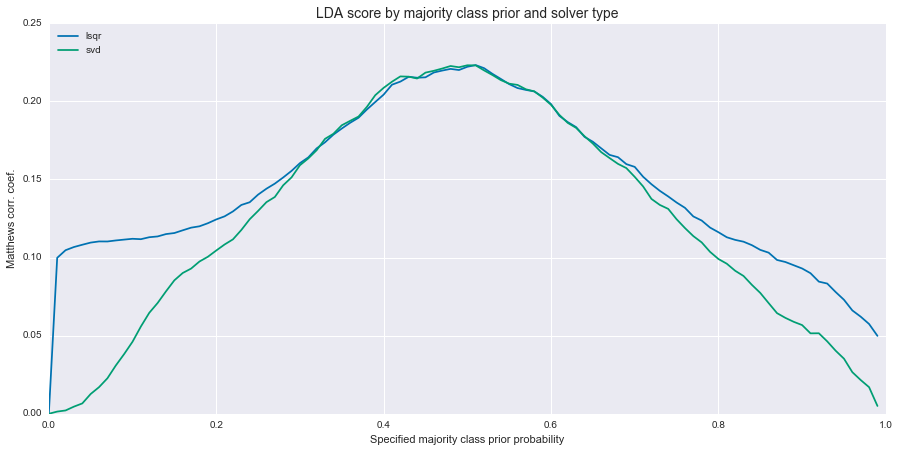

In [69]:
plt.figure(figsize=(15, 7))
solver_scores = {'svd':svd_scores, 'lsqr':lsqr_scores}
i=0
for key, scores_vector in solver_scores.items():
    plt.plot(np.arange(0,1,0.01), scores_vector, color=sns.color_palette('colorblind')[i], label=key)
    i+=1

plt.legend(loc=2); plt.title('LDA score by majority class prior and solver type', size=14)
plt.xlabel('Specified majority class prior probability')
plt.ylabel('Matthews corr. coef.')
plt.show()

In [72]:
optimum_priors = lda_gridCV.best_params_['priors']
optimum_priors

[0.51000000000000001, 0.48999999999999999]

The maximum score of both solver methods was similar, however least-squares supports shrinkage so I chose it.

In [74]:
# Shrinkage optimisation
lda_shrinkage_gridCV = GridSearchCV(LinearDiscriminantAnalysis(solver='lsqr', priors=optimum_priors),
                                    param_grid = {'shrinkage':np.arange(0,1,0.01)},
                                    scoring=opt_metric)
lda_shrinkage_gridCV.fit(Training['O_Filtered'], Training['R_Filtered']);

shrinkage_scores = []
for shrinkage_result in lda_shrinkage_gridCV.grid_scores_:
    shrinkage_scores.append(shrinkage_result[1])

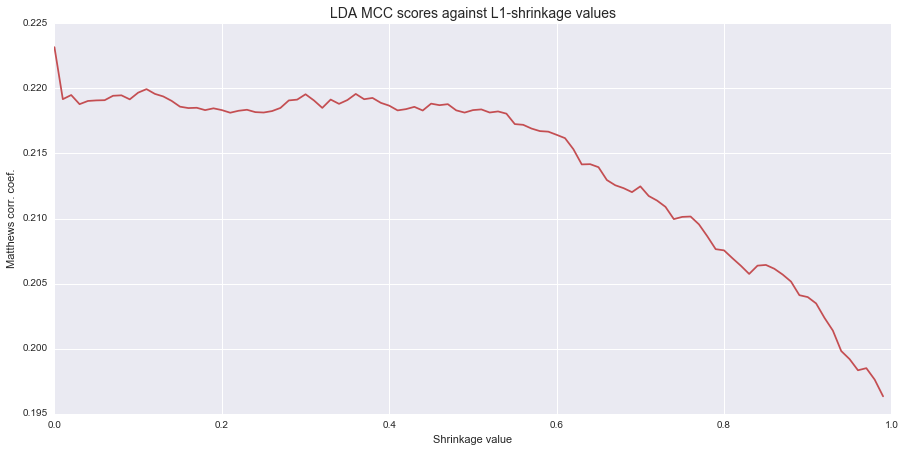

In [75]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(0,1,0.01), shrinkage_scores, color=sns.color_palette('deep')[2])
plt.xlabel('Shrinkage value'); plt.ylabel('Matthews corr. coef.')
plt.title('LDA MCC scores against L1-shrinkage values', size=14);

This plot suggested that no shrinkage produced the classifier with the highest score on the training set - I suspected that this was simply a case of overfitting, however I proceded in line with it regardless.

In [100]:
optimum_shrinkage = lda_shrinkage_gridCV.best_params_['shrinkage']
optimised_lda = LinearDiscriminantAnalysis(solver='lsqr', priors=optimum_priors, shrinkage=optimum_shrinkage)
optimised_lda.fit(Training['O_Filtered'], Training['R_Filtered']);

This classifier's performance is postponed until part (iii) of this section.

#### 5.2. *Filtering using lasso on a logistic regression classifier fit to the `Large`  dataset, then using the resulting dataset to train KNN (a story of verbose titles and cowboys)*

I was curious to see how a non-parametric classifier performed on this dataset, but was aware that KNN struggles with data of many dimensions and that the `Filtered` dataset still wasn't sufficiently small. I also wanted to see which features of the original dataset were influential in the direction chosen by LDA - `sklearn`'s `LDA` object doesn't allow access to the components of its direction. 

LDA and logistic regression (LR) for binary classification have the same form (i.e. $\text{logit} = \beta_0 +\beta_1 X_1 + ... + \beta_p X_p$); consequently I reasoned that the features with large $\beta$s in a LR model would also be major components in the direction chosen under LDA*.

<small>*In spite of the fact that they're fit slightly differently</small>

To understand the direction chosen by LDA and to produce a dataset that was manageable for KNN, I used the lasso to perform stepwise elimination of the `Large` dataset's features.

I started by shrinking the coefficients across quite a coarse grid to see at what approximate regularisation strength coefficients would start disappearing.

In [ ]:
# List of regularisation strengths
C_values = np.concatenate([np.arange(0.001,0.01,0.001), np.arange(0.01,0.1,0.01), np.arange(0.1,1,0.1)])

# Optimise a LR classifier by varying the reg. strength
lr_gridCV = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', warm_start=True, random_state=0),
                        param_grid={'C':C_values}, scoring=opt_metric)
lr_gridCV.fit(Training['O_Large'], Training['R_Large']);

lr_scores = []
for scores in lr_gridCV.grid_scores_: lr_scores.append(scores[1])

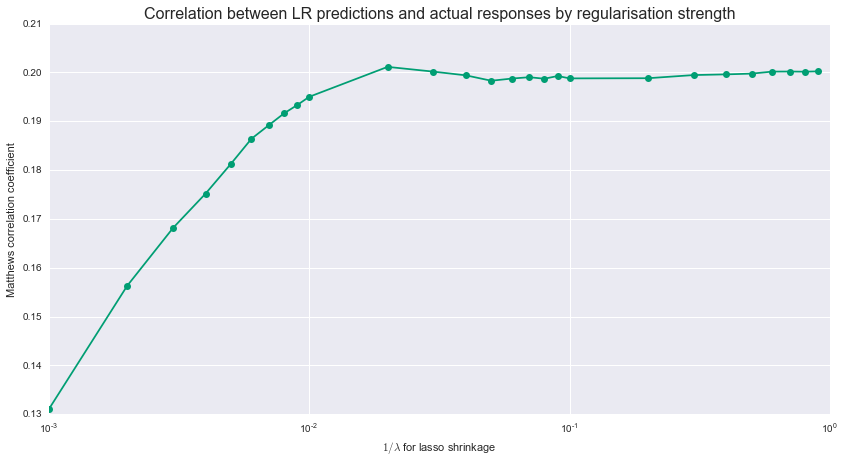

In [82]:
# Display classifier performance by reg. strength
plt.figure(figsize=(14,7))
plt.plot(C_values, lr_scores, marker='o', color=sns.color_palette('colorblind')[1])
plt.title('Correlation between LR predictions and actual responses by regularisation strength', size=16)
plt.xscale('log'); plt.xlabel('$1/\lambda$ for lasso shrinkage');
plt.ylabel('Matthews correlation coefficient');

In [83]:
# Extract coefficients of best LR model
lr_coefficients = pd.Series(lr_gridCV.best_estimator_.coef_.flatten(), index=Training['O_Large'].columns)

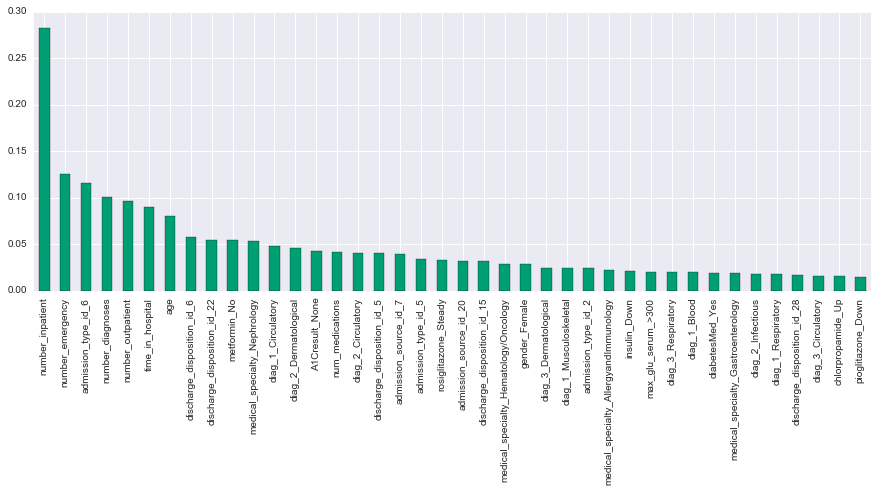

In [84]:
# Visualise coefficient sizes in a bar chart to show relative importance to decision boundary
plt.figure(figsize=(15,5))
lr_coefficients.loc[abs(lr_coefficients)>0].sort_values(ascending=False).head(40).plot(kind='bar', color=sns.color_palette('colorblind')[1]);
plt.xticks(rotation=90);

In [85]:
lr = LogisticRegression(penalty='l1', C=0.001)
lr.fit(Training['O_Large'], Training['R_Large'])
shrunk_coefficients = pd.Series(lr.coef_.flatten(), index=Training['O_Large'].columns)
shrunk_coefficients = shrunk_coefficients.loc[abs(shrunk_coefficients)>0].sort_values(ascending=False)

Comparison of the largest coefficients to the correlations between each feature and readmission status.

In [87]:
shrunk_coefficients

number_inpatient               0.202303
number_diagnoses               0.087469
time_in_hospital               0.036369
diabetesMed_Yes                0.031526
age                            0.027130
number_emergency               0.022257
number_outpatient              0.018719
diag_1_Neoplasmic             -0.003169
diabetesMed_No                -0.004764
discharge_disposition_id_11   -0.127693
dtype: float64

In [88]:
correlations_df['readmitted'].sort_values()[0:8]

number_inpatient              -0.151702
time_in_hospital              -0.097093
number_diagnoses              -0.092704
age                           -0.067701
num_medications               -0.067102
number_emergency              -0.065951
diabetesMed_Yes               -0.062756
discharge_disposition_id_22   -0.060275
Name: readmitted, dtype: float64

In [90]:
correlations_df['readmitted'].sort_values(ascending=False)[0:4]

readmitted                     1.000000
discharge_disposition_id_11    0.089272
discharge_disposition_id_1     0.066854
diabetesMed_No                 0.062756
Name: readmitted, dtype: float64

Following this step I used the 10 features with the largest absolute LR coefficients to optimise a KNN model.

In [93]:
# Smaller datasets to train KNN with, based on remaining coefficients after shrinkage on a LR classifier
Training['O_KNN'] = Training['O_Large'].ix[:, shrunk_coefficients.index]
Training['R_KNN'] = Training['R_Large'].copy()
Testing['O_KNN'] = Testing['O_Large'].ix[:, shrunk_coefficients.index]
Testing['R_KNN'] = Testing['R_Large'].copy()

knn_gridCV = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors':np.arange(5, 51, 5),
                                                              'weights':['uniform']}, scoring=opt_metric)
knn_gridCV.fit(Training['O_KNN'], Training['R_KNN']);

In [94]:
def plot_gridSearch_performance(grid_scores):
    param_values = []; scores_mu = []
    for i in range(0, len(grid_scores)):
        param_values.append(grid_scores[i][0]['n_neighbors'])
        scores_mu.append(grid_scores[i][1])
    plt.figure(figsize=(15, 5))
    plt.plot(param_values, scores_mu, linestyle='None', marker='o')

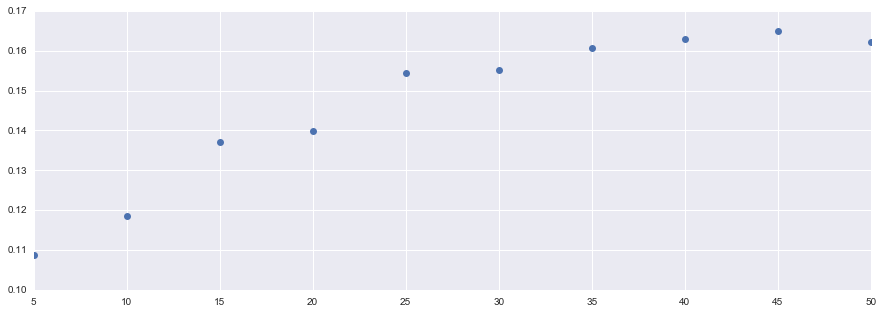

In [95]:
plot_gridSearch_performance(knn_gridCV.grid_scores_)

In [96]:
knn_predictions = cross_val_predict(knn_gridCV, Training['O_KNN'], Training['R_KNN'])

In [97]:
print(metrics.confusion_matrix(Training['R_KNN'], knn_predictions))

[[22522  4472]
 [12750  5514]]


#### 5.3. *The big showdown - KNN vs. LDA (vs. dummy)*

In [104]:
Predictions = {}
Predictions['LDA'] = optimised_lda.predict(Testing['O_Filtered'])
Predictions['KNN'] = knn_gridCV.predict(Testing['O_KNN'])
Predictions['Dummy'] = dummy_classifier.predict(Testing['O_Filtered'])

In [109]:
print(metrics.classification_report(Testing['R_Filtered'], Predictions['LDA']))

             precision    recall  f1-score   support

          0       0.68      0.63      0.66      8931
          1       0.52      0.57      0.54      6155

avg / total       0.62      0.61      0.61     15086



In [111]:
print(metrics.classification_report(Testing['R_KNN'], Predictions['KNN']))

             precision    recall  f1-score   support

          0       0.63      0.80      0.71      8931
          1       0.53      0.32      0.40      6155

avg / total       0.59      0.61      0.58     15086



In [110]:
print(metrics.classification_report(Testing['R_Filtered'], Predictions['Dummy']))

             precision    recall  f1-score   support

          0       0.59      0.60      0.60      8931
          1       0.41      0.40      0.40      6155

avg / total       0.52      0.52      0.52     15086



In [113]:
print(metrics.confusion_matrix(Testing['R_Filtered'], Predictions['LDA']))

[[5667 3264]
 [2627 3528]]


In [112]:
print(metrics.confusion_matrix(Testing['R_KNN'], Predictions['KNN']))

[[7186 1745]
 [4167 1988]]


In [115]:
print(metrics.accuracy_score(Testing['R_Filtered'], Predictions['LDA']))

0.60950550179


In [114]:
print(metrics.accuracy_score(Testing['R_KNN'], Predictions['KNN']))

0.608113482699


In [116]:
print(metrics.accuracy_score(Testing['R_KNN'], Predictions['Dummy']))

0.520681426488


- LDA was the most precise overall (predicted correctly/predicted)
- LDA had best recall of `readmitted=True` (predicted correctly/observed) - possibly the most valuable attribute
- Both KNN and LDA had better recall overall than the dummy classifier, however KNN's was worse for `readmitted=True` alone. 

It appeared that KNN and LDA were identically accurate, with LDA having the edge in precision. LDA could also be tuned more reliably to favour prediction of one class over the other. These characteristics suggested to me that LDA was the model of choice. Admittedly, the gains made by the model over the dummy classifier are modest - a 9% gain in overall accuracy and a 10% improvement in precision - however the LDA classifier offers a boundary which can be shifted according to some loss function, and provides insight into what factors influence patient readmission. It in this last point where its the classifier's value lies. Additionally, the LDA classifier represents substantial gains in recall - by 17% - over the dummy classifier .

Why was it so demanding to achieve such meagre improvements? Because patients that were and were not readmitted were similar in most regards except their readmission status. The differences that did exist were quite fine and consequently only offered limited predictive potential.

It may be that the models' performances would have been enhanced by removing the `>30 days` class entirely, providing better separation between the two extreme classes; in reality, such a model might be more useful as it is patients that are readmitted very soon after discharge that need to be anticipated.

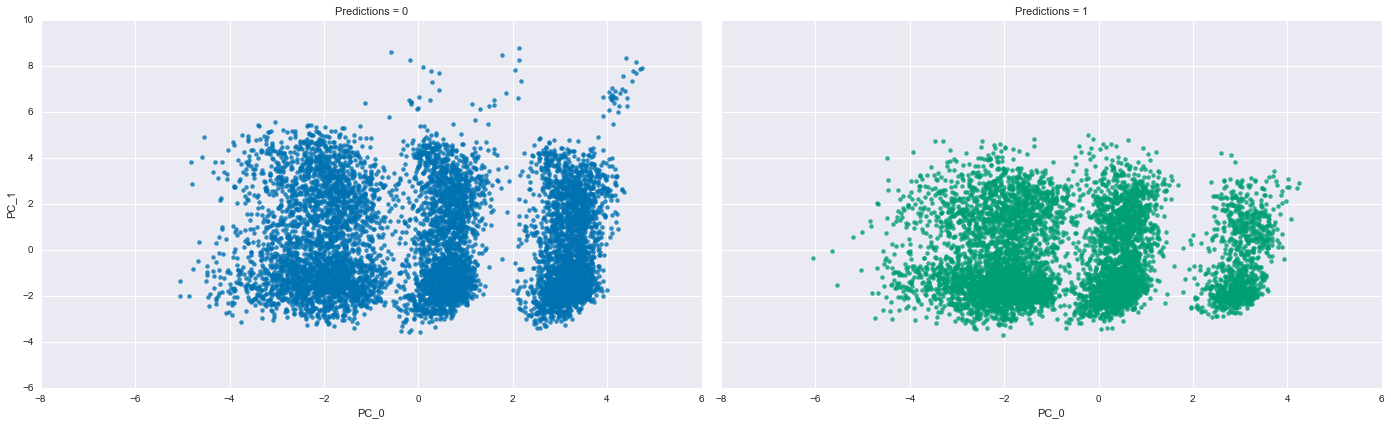

In [268]:
sns.lmplot(data=Testing['O_Filtered'].join(pd.Series(Predictions['LDA'], index=Testing['O_Filtered'].index, name='Predictions')),
           x='PC_0', y='PC_1', size=6, aspect=1.618, fit_reg=False, hue='Predictions', palette='colorblind', col='Predictions');

The first PC (i.e `PC_0`) can be thought of as a '`Not using medications` direction - a negative value suggests that a patient is using diabetes medication or has had a change to their medication, whereas a positive value suggests that a patient does not take diabetes medication. Referring to the right-hand chart, we can see that the LDA algorithm favours classifying medication-using patients as `readmitted` over patients that don't take medication. Additionally, it appears that patients that score highly in the direction of the second PC are less likely to have the prediction `readmitted=True`. The second PC is a mixture of admission source and admission types, with some lab procedures thrown in for good measure. Patients that score negatively in its direction are more likely to have come from `admission_source_id_7` and be of type `admission_type_id_1`. I suspect these identifiers are associated with an ICU and emergency admission respectively.

In [270]:
# PC 1 loadings
PC_1_loadings = pd.DataFrame(pca.components_, index=pc_labels,
             columns=Dataset['Large OHE'].columns.drop('readmitted')).loc['PC_1',:]
PC_1_loadings[abs(PC_1_loadings)>0.1].sort_values()

admission_source_id_7                          -0.395643
admission_type_id_1                            -0.389132
num_lab_procedures                             -0.217306
medical_specialty_InternalMedicine             -0.154358
medical_specialty_Emergency/Trauma             -0.130160
max_glu_serum_None                             -0.120204
number_diagnoses                               -0.101844
diag_1_Childbirth                               0.105183
medical_specialty_Orthopedics-Reconstructive    0.109120
medical_specialty_ObstetricsandGynecology       0.114845
A1Cresult_None                                  0.132169
admission_type_id_5                             0.135282
medical_specialty_Orthopedics                   0.137067
admission_source_id_17                          0.142060
num_procedures                                  0.153586
diag_1_Musculoskeletal                          0.195219
admission_type_id_3                             0.299980
admission_source_id_1          

#### 5.4. *Requiem for stepwise regression*

At one point I attempted to use a home-cooked stepwise selection function to optimise a logistic regression (LR) classifier. Sadly, it didn't provide improvements over the methods shown already, and I didn't want to make this document *too* verbose; however, I couldn't bear to put it out to pasture, so here it is.

In [ ]:
def forward_stepwise_selection(X_train, y_train, termination_step=len(X_train.columns.values), score_metric='f1', class_weights='balanced'):
    # Returns a list of feature labels that are in order of how much they improve a logistic regression classifier
    # Uses k-fold cross validation with k = 5
    p = len(X_train.columns) # Number of features
    remaining_features = (X_train.columns.values).tolist()
    selected_features = []
    trialled_features = []
    step_scores = []
    for k in range(0, termination_step): # Iterate as many times as there are features
        step_max_score = 0
        for j in range(0, p-k): # For each of the features that haven't yet been added to the model
            trialled_features = selected_features+[remaining_features[j]]
            cross_validated_score = cross_val_score(LogisticRegression(class_weight=class_weights),
                                                 X_train[trialled_features], y_train, cv=5, scoring=score_metric)
            trialled_classifier_score = cross_validated_score.mean()
            if trialled_classifier_score > step_max_score: # See which improves the model's accuracy the most
                step_max_score = trialled_classifier_score
                step_feature_index = j
        best_feature_of_step = remaining_features[step_feature_index]
        selected_features.append(best_feature_of_step)  # Then add that feature to the model
        del remaining_features[step_feature_index] # And remove it from the list of features that still need to be added
        step_scores.append(step_max_score) # Make a record of the model's accuracy with this number of features
        print("Completed step ", str(k), ", score is ", round(step_max_score, 2))
    return (selected_features, step_scores)

# 6. Unsupervised Learning

Unsupervised learning is a potentially endless endeavor, so I chose to focus on two activities:
1. Clustering on the entire dataset, with visualisations of the first two PCs.
2. Distilling high-dimensional forms in the data down into two dimensions using t-SNE, then seeing what readmission rates were like in different clusters.

I began by creating a dataset containing all observations.

In [117]:
Dataset['Unsupervised'] = pd.concat([Training['O_Filtered'].loc[:,:],
                                     Testing['O_Filtered'].loc[:,:]])

pc_50_labels = ['PC_'+str(j) for j in range(0, 51)]

# Some algorithms used demand alot of memory, so we'll need to use a smaller dataset for those
chosen_indices = np.random.choice(Dataset['Unsupervised'].index, 1000, replace=False)
Dataset['Unsupervised small'] = Dataset['Unsupervised'].ix[chosen_indices, pc_50_labels]

#### 6.1. *Principal component clustering: a story of bereavement*

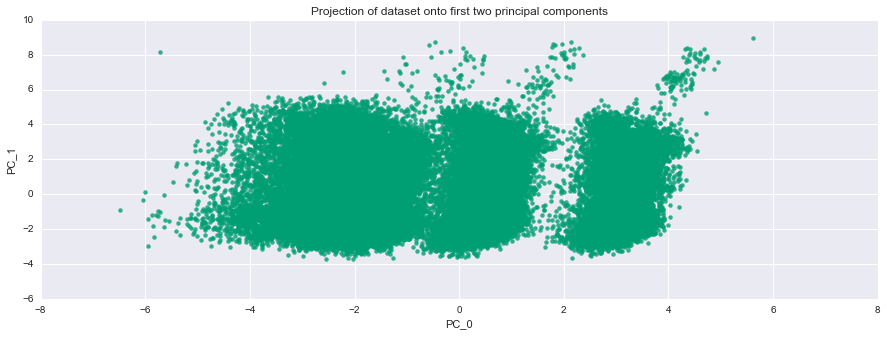

In [118]:
plt.figure(figsize=(15,5))
sns.regplot(x='PC_0', y='PC_1', data=Dataset['Unsupervised'], color=sns.color_palette('colorblind')[1], fit_reg=False);
plt.title('Projection of dataset onto first two principal components');

From this plot it appeared that there were three primary clusters - one especially large one on the left, and two identically shaped smaller ones on the right. I was curious to know what these represented, and consequently went about trying to extract them.

To begin with, I used k-means clustering to split the dataset into the clusters identified above. I noted, however, that k-means will tend to extract clusters of similar sizes, which meant that I had to perform the operation twice - once to split the dataset into the large leftward and coupled right clusters, then again to split the coupled clusters in twain.

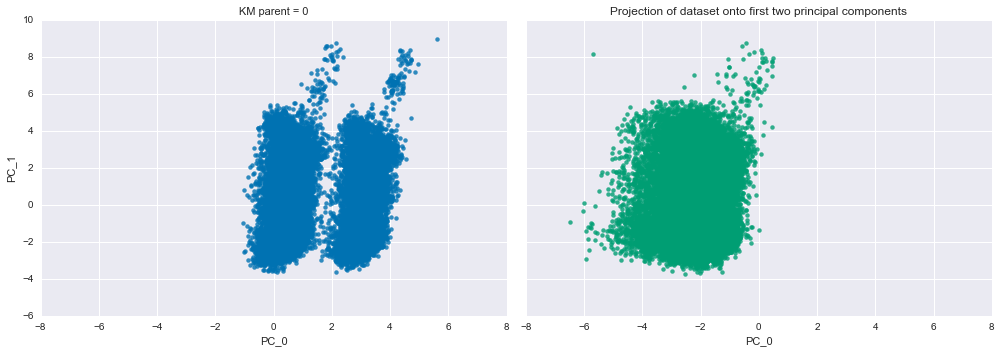

In [119]:
KMClusterers = {} # what an inelegant word
KMClusterers['Parent'] = KMeans(n_clusters=2, random_state=0, max_iter=300)

Clusters = {}
Clusters['KM parent'] = pd.Series(KMClusterers['Parent'].fit_predict(Dataset['Unsupervised']),
                              index=Dataset['Unsupervised'].index, name='KM parent')

sns.lmplot(x='PC_0', y='PC_1', col='KM parent', data=Dataset['Unsupervised'].join(Clusters['KM parent']), palette='colorblind',
           hue='KM parent', fit_reg=False, size=5, aspect=1.4);
plt.title('Projection of dataset onto first two principal components');

Next I took the two smaller clusters in the left-hand panel and repeat the clustering operation, making the differences between the two clusters irreconcilable.

In [120]:
Dataset['Unsupervised KM subset'] = Dataset['Unsupervised'].loc[Clusters['KM parent']==0, :]

In [121]:
KMClusterers['Child'] = KMeans(n_clusters=2, random_state=0, max_iter=300)
Clusters['KM child'] = pd.Series(KMClusterers['Child'].fit_predict(Dataset['Unsupervised KM subset']),
                                 index=Dataset['Unsupervised KM subset'].index, name='KM child');

All that remains is to combine the two sets of clusters and visualize the result.

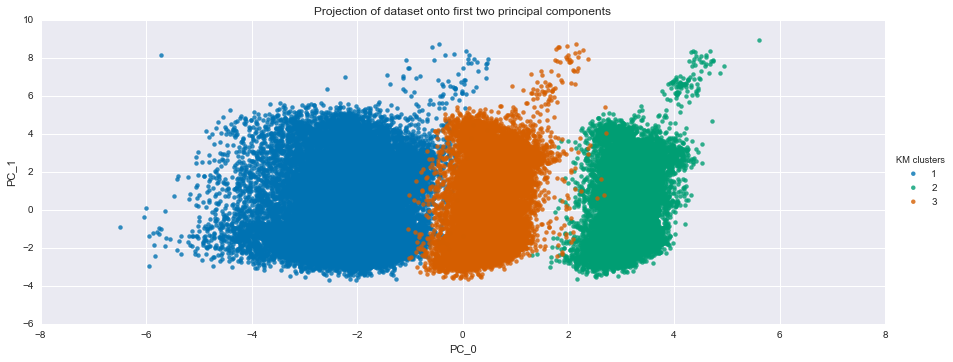

In [123]:
Clusters['KM'] = Clusters['KM child'] + 2 
Clusters['KM'] = pd.concat([Clusters['KM'],
               Clusters['KM parent'].loc[Clusters['KM parent'].index.drop(Clusters['KM child'].index)]],
               axis=0)
Clusters['KM'].name = 'KM clusters'

sns.lmplot(x='PC_0', y='PC_1', data=Dataset['Unsupervised'].join(Clusters['KM']),
           palette='colorblind', hue='KM clusters', fit_reg=False, size=5, aspect=2.5);
plt.title('Projection of dataset onto the first two principal components');

Wunderbar - we have three nicely partitioned clusters that can now be interrogated for their meaning with respect to the original dataset.

In [126]:
# Make datasets consisting of samples from each cluster
Dataset['KM 1'] = Dataset['Trimmed'].loc[Clusters['KM']==1, :]
Dataset['KM 2'] = Dataset['Trimmed'].loc[Clusters['KM']==2, :]
Dataset['KM 3'] = Dataset['Trimmed'].loc[Clusters['KM']==3, :]

In [127]:
# Create a dataframe containing the means of each feature for each of the above datasets
k1_mus = Dataset['KM 1'].describe().ix['mean',:]
k2_mus = Dataset['KM 2'].describe().ix['mean',:]
k3_mus = Dataset['KM 3'].describe().ix['mean',:]
kn_mus = pd.concat([k1_mus, k2_mus, k3_mus], axis=1)

In [128]:
kn_mus.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']

I normalized the features to allow features of different magnitudes to be compared in a similar way.

In [129]:
kn_mus = kn_mus.apply(func=(lambda row: row/(row.mean())), axis=1)

In [130]:
cblind = [sns.color_palette('colorblind')[0],sns.color_palette('colorblind')[1],sns.color_palette('colorblind')[2]] 

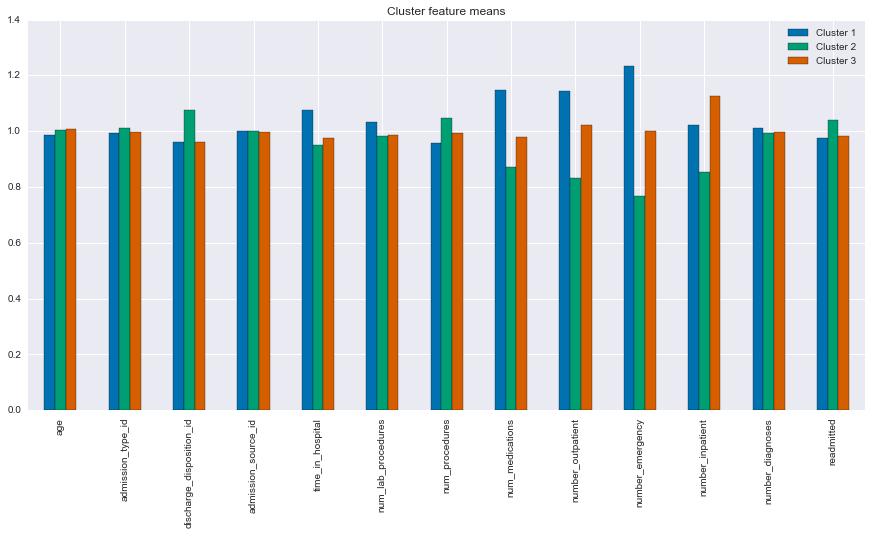

In [131]:
kn_mus.plot.bar(cmap=ListedColormap(cblind), figsize=(15, 7), title='Cluster feature means');

In [132]:
kn_mus.apply(func=(lambda row: row/(row.mean())), axis=1) # Scaling the means to better represent cluster differences

,Cluster 1,Cluster 2,Cluster 3
age,0.986350,1.005507,1.008144
admission_type_id,0.994391,1.010118,0.995491
discharge_disposition_id,0.961746,1.075683,0.962571
admission_source_id,1.001827,0.999966,0.998207
time_in_hospital,1.074667,0.951387,0.973945
num_lab_procedures,1.032297,0.983117,0.984586
num_procedures,0.958633,1.046440,0.994926
num_medications,1.149239,0.870161,0.980600
number_outpatient,1.145165,0.833544,1.021290
number_emergency,1.233205,0.767615,0.999180


From the above bar chart and table I made a few observations:
- Patients in the first cluster spent between a third and half a day more longer in hospital
- Patients in the first cluster had about 5% more lab procedures than those in clusters two or three, and were, on average, using between 15 and 25% more medicaments.
- Patients in the first cluster had a record of more encounters (inpatient, emergency, and outpatient).

I could have come to similar (albeit less quantitatively specific) conclusions about the differences between the clusters by considering the principal component loadings. The clusters were separated in the direction of the first principal component (i.e. PC_0), which meant that by looking at this component's loadings it would be possible to identify what factors changed as we moved in its direction. Further, the loadings would provide insight as to which categorical features are varying in the direction of `PC_0`.

In [133]:
PC_0_loadings = pd.DataFrame(pca.components_, index=pc_labels,
             columns=Dataset['Large OHE'].columns.drop('readmitted')).loc['PC_0',:]
PC_0_loadings[abs(PC_0_loadings)>0.1].sort_values()

change_Ch              -0.386424
diabetesMed_Yes        -0.368718
metformin_Steady       -0.193141
num_medications        -0.153934
insulin_Steady         -0.131320
insulin_Down           -0.130407
insulin_Up             -0.127360
pioglitazone_Steady    -0.117409
rosiglitazone_Steady   -0.116509
glipizide_Steady       -0.108773
glyburide_No            0.108703
rosiglitazone_No        0.120638
glipizide_No            0.122204
pioglitazone_No         0.122954
metformin_No            0.211173
insulin_No              0.271073
diabetesMed_No          0.368718
change_No               0.386424
Name: PC_0, dtype: float64

We can see that this direction was effectively expressing a patient's usage of diabetes medication - lower scores suggested that a patient had a change in medication, was using at least one medication, tended to use more medications, or were using insulin/metformin; contrariwise, larger scores suggested that a patient wasn't using any diabetes medications.

What this meant for the analysis was that patients in cluster 1 tended to use medications, patients in cluster 2 tended not to, and patients in cluster 3 tended to somewhere inbetween. With this in mind, I thought it would be interesting to see how diagnosis frequencies differed between the clusters.

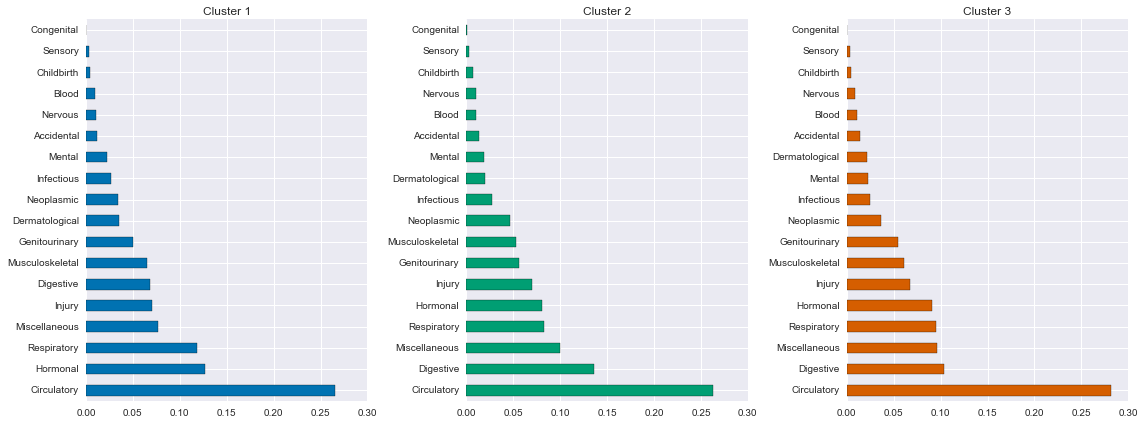

In [134]:
def normalised_value_counts(series):
    return series.value_counts()/len(series)

f, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(16,6))
N_bars = np.arange(len(Dataset['KM 1'].diag_1.unique()))*2
for i in range(0,3):
    normalised_value_counts(Dataset['KM '+str(i+1)].diag_1).plot(kind='barh', ax=ax[i],
                                                                 color=sns.color_palette('colorblind')[i])
    ax[i].set_title('Cluster '+str(i+1))
    
plt.tight_layout()

Observations:
- All clusters had circulatory diagnoses top
- Patients on fewer/no diabetes medications were readmitted much more frequently for digestive problems, whereas patients with many were admitted more frequently for hormonal problems.

To get a better idea of what specific diagnoses were constituting the hormonal and digestive diagnosis frequencies in clusters 1 and 2, I referred back to the original dataset. The range of values for hormonal diseases was 240-79, and 520-579 for digestive diseases.

In [135]:
Diagnoses = {}
for i in range(0,3):
    Diagnoses['Cluster '+str(i+1)] = pd.to_numeric(Dataset['Encoded response'].diag_1.loc[Clusters['KM'].loc[Clusters['KM']==i+1].index],
                                                   errors='coerce')
    Diagnoses['Cluster '+str(i+1)].dropna()
    
c1_hormonal_diag = (Diagnoses['Cluster 1'] < 280) & (Diagnoses['Cluster 1'] >= 240)
c1_digestive_diag = (Diagnoses['Cluster 1'] < 580) & (Diagnoses['Cluster 1'] >= 520)
c2_hormonal_diag = (Diagnoses['Cluster 2'] < 280) & (Diagnoses['Cluster 2'] >= 240)
c2_digestive_diag = (Diagnoses['Cluster 2'] < 580) & (Diagnoses['Cluster 2'] >= 520)

In [136]:
# ICD9 hormonal diagnosis codes by count for cluster 1
Diagnoses['Cluster 1'].loc[c1_hormonal_diag].value_counts().head(5)

250.80    490
276.00    445
250.02    366
250.60    316
250.70    206
Name: diag_1, dtype: int64

In [137]:
# ICD9 hormonal diagnosis codes by count fir cluster 2
Diagnoses['Cluster 2'].loc[c2_hormonal_diag].value_counts().head(5)

276.0    321
250.8    251
278.0    121
250.6     74
250.7     59
Name: diag_1, dtype: int64

250.80: hyperglycemic (high blood sugar, associated with diabetes mellitus)<br>
276.00: hypernatremia (high blood sodium, associated with diabetes insipidus)<br>
250.x: diabetes mellius w/ complication<br>
278: obesity <br>
Diabetes insipidus is a form of diabetes that causes excessive urination because a urine-regulating hormone isn't produced. <br>
Diabetes mellitus is what people usually mean when they say 'diabetes' - it's a health problem in which the body struggles to regulate blood-sugar levels.

In [138]:
# ICD9 digestive diagnosis codes by count for cluster 1
Diagnoses['Cluster 1'].loc[c1_digestive_diag].value_counts().head(5)

574.0    219
577.0    196
562.0    180
560.0    125
578.0    112
Name: diag_1, dtype: int64

In [139]:
# ICD9 digestive diagnosis codes by count for cluster 2
Diagnoses['Cluster 2'].loc[(Diagnoses['Cluster 2'] < 580) & (Diagnoses['Cluster 2'] >= 520)].value_counts().head(5)

562.0    256
574.0    232
560.0    219
577.0    188
578.0    149
Name: diag_1, dtype: int64

562.0: Diverticula of intestine (small bulges formed in colon, may be inflamed) <br>
574.0: Gallstones (associated with obesity, among other things) <br>
560.0: Intestinal obstruction <br>
577.0: Pancreatic diseases <br>

The distribution of diagnoses suggested that hormonal diseases were more prominent in patients that took more diabetes-related medications than patients that took fewer or none at all, for whom digestive problems are more frequent. Diabetes-related prescriptions typically pertain to hormone control (e.g. insulin levels) therefore such medications are prescribed when a patient has a hormonal disease. It seems reasonable then, that patients that took more diabetes medications (i.e. patients in cluster 1) were more likely to be admitted with a hormonal disease as the primary diagnosis, whereas patients that took fewer diabetes medications (i.e. patients in cluster 2) weren't. 

This was hardly a startling revelation, however the clusters did highlight one very valuable point: patients that required more diabetes medications or had a change to their medication were markedly more likely to have been encountered before as an inpatient, outpatient, or in an emergency, and were more likely to be readmitted (see rates below).

In [140]:
normalised_value_counts(Dataset['KM 1'].readmitted)

2    0.571985
1    0.331695
0    0.096320
Name: readmitted, dtype: float64

In [141]:
normalised_value_counts(Dataset['KM 2'].readmitted)

2    0.653164
1    0.269769
0    0.077067
Name: readmitted, dtype: float64

#### 6.1. *t-SNE and me*

t-SNE is a neat method of mapping a dataset which has a form in many dimensions into a dataset with a form in two dimensions. I'm slightly paranoid that, even though I've passed a seed when calling the function, the function will not converge on the same result with each instantiation. This could make it quite difficult to write about in the context of a dynamic report - unless I use images from the run I used to build the model (which I have - please feel free to delete them if your runs are identical).

In [234]:
for p in np.arange(1, 101, 5):
    tsne = TSNE(n_components=2, perplexity=p, random_state=0, early_exaggeration=10, init='pca')
    Dataset['t-SNE p='+str(p)] = pd.DataFrame(tsne.fit_transform(Dataset['Unsupervised small']),
                                                 index = Dataset['Unsupervised small'].index,
                                                 columns=['Axis 0', 'Axis 1'])

*My initialisation*
<img src='t-SNE_perplexity_results.png'>

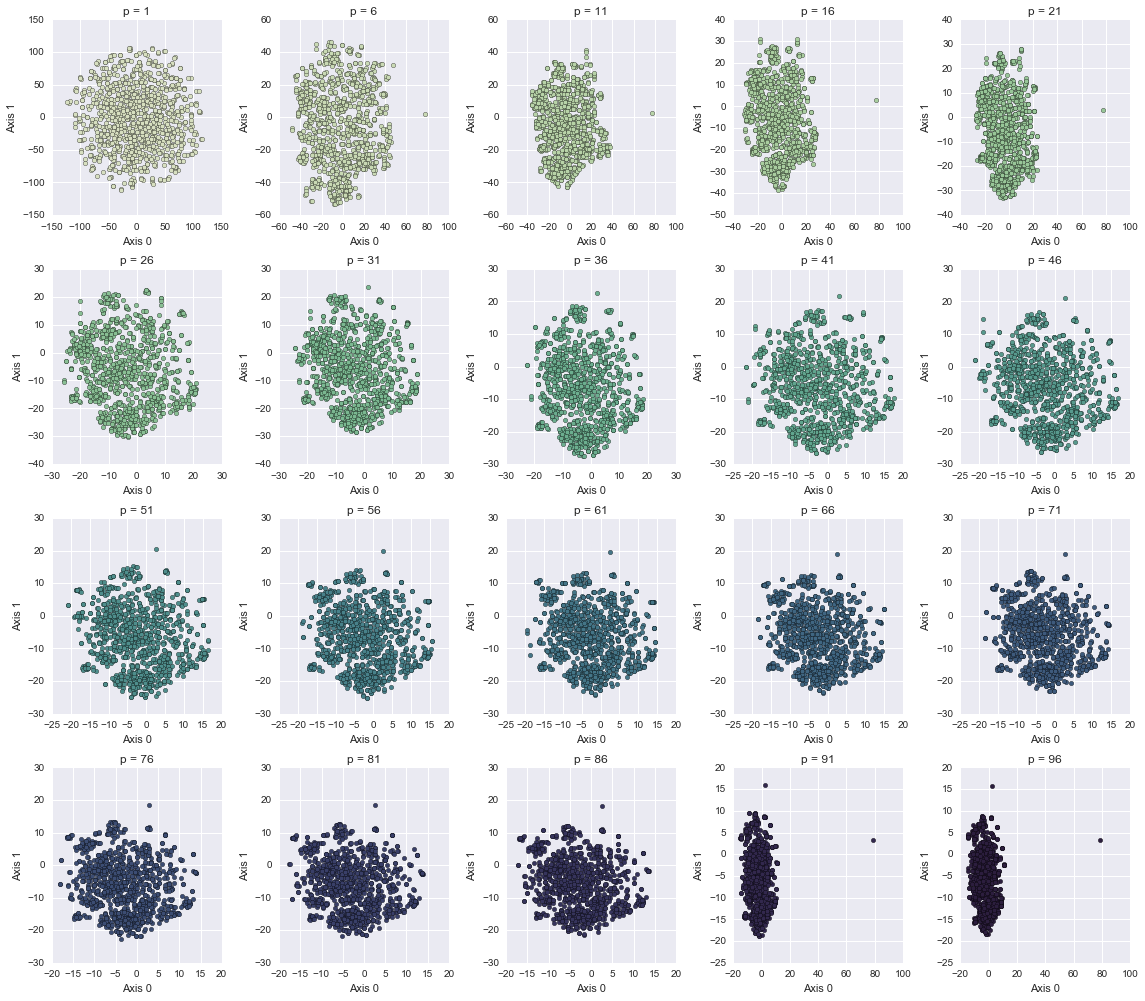

In [235]:
# Your initialisation
f, ax = plt.subplots(4, 5, sharex=False, sharey=False, figsize=(16,14))
for i, k in enumerate(np.arange(1,101, 5)):
    j = int(i/5)
    i = i - (int(i/5)*5)
    Dataset['t-SNE p='+str(k)].plot(kind='scatter', x='Axis 0', y='Axis 1',
                                    ax=ax[j, i], color=sns.cubehelix_palette(20, start=.5, rot=-.75)[int(k/5)])
    ax[j,i].set_title('p = '+str(k))
    
plt.tight_layout()

It looked as though a perplexity of about 56 brought out distinct clusters in the data, so I chose to use this value to proceed with clustering.

In [236]:
Dataset['t-SNE'] = Dataset['t-SNE p=56']

I chose to cluster this dataset using the DBSCAN algorithm, as it didn't require the number of clusters to be stipulated beforehand. To apply it effectively, I needed to make an informed choice of the `eps` hyperparameter.

*My distances distribution*
<img src='db_distances.png'>

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


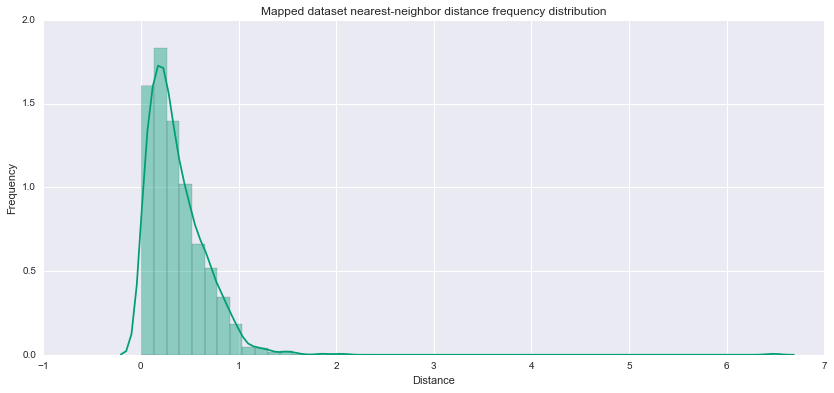

In [238]:
# Your distances distribution
distances = pairwise_distances(Dataset['t-SNE'])
neighbor_distances = [np.min(row[np.nonzero(row)]) for row in distances]

plt.figure(figsize=(14, 6))
sns.distplot(neighbor_distances, color=sns.color_palette('colorblind')[1]);
plt.title('Mapped dataset nearest-neighbor distance frequency distribution');
plt.xlabel('Distance'); plt.ylabel('Frequency')

I wanted an `eps` value such that there were between 2 and 10 major clusters formed, which meant it was necessary that `eps` was big enough for relatively close points to be clustered, but not so big that visibly discrete clusters were merged.

In [239]:
nb_clusters = []
for eps_value in np.arange(0.1, 10, 0.01):
    db = DBSCAN(eps=eps_value, min_samples=20)
    Clusters['DB'] = pd.Series(db.fit_predict(Dataset['t-SNE']), index=Dataset['t-SNE'].index, name='DBSCAN clusters')
    nb_clusters.append(len(Clusters['DB'].unique()))

*My cluster counts with eps*
<img src='db_cluster_counts.png'>

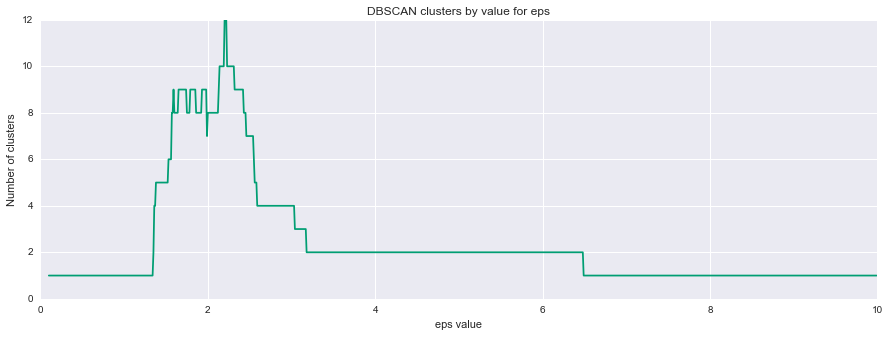

In [240]:
# Your cluster counts with eps
plt.figure(figsize=(15,5))
plt.plot(np.arange(0.1, 10, 0.01), nb_clusters, color=sns.color_palette('colorblind')[1]);
plt.xlabel('eps value'); plt.ylabel('Number of clusters');
plt.title('DBSCAN clusters by value for eps')

After iterating through several `min_samples`, I decided that classifying a core point on the basis of whether it had 10 points within a radius `eps` of it seemed reasonable; this was because it allowed the 'stable' (i.e. constant # clusters with varying eps) regions of the graph to be discerned easily, and...

We can see from the graph that the number of clusters rises then falls with increasing eps. The small number of clusters to the left of the peak is explained by the fact that for a small `eps`, most points will be classified as outliers. To the right of the peak, a large `eps` value means that the majority of points are being classified as core points, implying that few clusters will be formed because most points are directly reachable from many other points. I'm interested in clustering as many points as reasonably possible, so I chose to use a larger `eps` value that brough out 5 clusters - `eps=2.5`.

In [246]:
db = DBSCAN(eps=2.21, min_samples=20, random_state=0)
Clusters['DB'] = pd.Series(db.fit_predict(Dataset['t-SNE']), index=Dataset['t-SNE'].index, name='DBSCAN clusters')

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cluster\dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


All that remains now is to visualise the result.

*My result*
<img src='db_clusters.png'>

In [247]:
Dataset['t-SNE with clusters'] = Dataset['t-SNE'].join(Clusters['DB'])

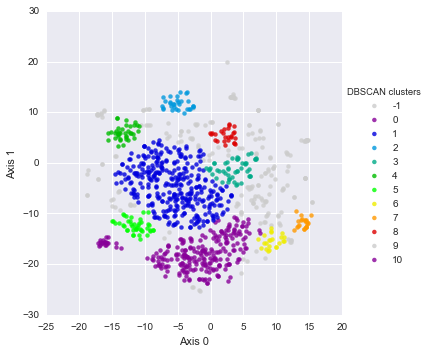

In [243]:
# Your result
outlier_palette = [(0.8, 0.8, 0.8)];
outlier_palette = outlier_palette + sns.color_palette('spectral', n_colors=9)

sns.lmplot(data=Dataset['t-SNE with clusters'],
           x='Axis 0', y='Axis 1', hue='DBSCAN clusters', palette=outlier_palette,
          size=5, aspect=1, fit_reg=False);

In [248]:
cluster_counts_df = pd.DataFrame()
for cluster_nb in Clusters['DB'].unique():
    cluster_indices = (Clusters['DB'][Clusters['DB']==cluster_nb]).index
    cluster_counts = normalised_value_counts(Dataset['Encoded response'].loc[cluster_indices,'readmitted'])
    cluster_counts = cluster_counts.append(pd.Series(len(cluster_indices), index=['foo'], name='bar'))
    cluster_counts.name = 'Cluster '+str(cluster_nb)
    cluster_counts_df = pd.concat([cluster_counts_df, cluster_counts], axis=1)

priors = normalised_value_counts(Dataset['Encoded response'].loc[Clusters['DB'].index,'readmitted'])
priors.name = 'Priors'
cluster_counts_df = pd.concat([cluster_counts_df, priors], axis=1)
cluster_counts_df.index = ['No', '>30 days', '<30 days', 'Nb. points in cluster']
pd.set_option('max_columns',15)
round(cluster_counts_df,2)

C:\Users\admin\Anaconda3\lib\site-packages\pandas\indexes\api.py:71: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  result = result.union(other)


,Cluster 0,Cluster 1,Cluster -1,Cluster 3,Cluster 4,Cluster 8,...,Cluster 10,Cluster 7,Cluster 2,Cluster 9,Cluster 6,Priors
No,0.69,0.56,0.61,0.60,0.59,0.65,...,0.70,0.52,0.55,0.60,0.39,0.60
>30 days,0.23,0.33,0.32,0.36,0.35,0.27,...,0.15,0.33,0.35,0.35,0.52,0.31
<30 days,0.08,0.11,0.07,0.04,0.05,0.08,...,0.15,0.14,0.10,0.05,0.09,0.09
Nb. points in cluster,225.00,326.00,178.00,50.00,37.00,26.00,...,20.00,21.00,31.00,20.00,23.00,NaN


We can see that the patients of different readmission classes are not evenly distributed between the clusers, potentially providing a route to improved patient classification by feeding clusters into different supervised classifiers.

# 7. Summary

#### What was produced
*Mining*:
- A null-free, outlier-free dataset, with convenient datatypes, suitably encoded variables, and aggregated diagnoses features

*Exploratory data analysis*:
- A concrete understanding of diagnosis frequencies across the patient population
    - Most frequent were:
        1. Circulatory
        2. Hormonal
        3. Respiratory
        4. Digestive
- A visual representation of where the differences between readmitted and not-readmitted patients are
- Investigation of dissimilarity between clusters, and why it was reasonable to merge `>30 days` and `<30 days`
- Quantification of the correlation between intervallic categorical features, and a discussion of how these correlations would influence the analysis

*Dimensionality reduction*:
- A filtered dataset that had an improved signal-noise ratio, with demonstrated benefits in stability and accuracy for an unoptimised LDA classifier.
- Removal of collinear components from the dataset

*Supervised learning*:
- Validated LDA classification algorithm that is 8% more accurate and 10% more precise than guessing according to the prior probabilities, with a 17% improvement in recall of `readmitted=True` patients (correct predictions/observed)
- An optimised linear decision boundary that can be shifted to reflect the relative cost of readmission to no-readmission
- A list of which factors are most strongly associated with being readmitted, based on the outcome of lasso shrinkage on a logistic regression classifier
    - number_inpatient, number_diagnoses, time_in_hospital, diabetesMed, age, number_emergency, number_outpatient, diag_1_Neoplasmic, diabetesMed_No, discharge_disposition_id_11
- Projection of the decision boundary onto the first two principal components
    
*Unsupervised learning:
- Recursive use of K-means clustering to split the dataset into three clusters
    - Analysis of these clusters - an overview of the essential differences between patients within them.
- t-SNE visualisation of the dataset, followed by density-based clustering
    - Demonstration that there exist clusters within the dataset that could be exploited for better predictive performance by multiple supervised classifiers.

#### What I learned
- Alot<br><br>
- Clean data is mega-important for producing a successful classifier; thinking carefully about how to impute, remove outliers, aggregate/create features, and remove noisy features cannot be overstated in its importance towards getting things to work!
<br><br>
- Clean data is generally more important than using the 'best' algorithm in making useful predictions.
<br><br>
- Choice of scoring metric is critical when optimising a classifier - accuracy or precision can easily result in trivial fits that guess in line with the dataset priors. In this analysis, the Matthews correlation coefficient was chosen, because I was interested in producing a classifier whose predictions correlated as strongly as possible with a patient's class.
<br><br>
- No scoring metric can capture the performance of a binary classifier as decisively as a confusion matrix, which was a useful tool when evaluating the performance of the supervised classifiers designed.
<br><br>
- Feature aggregation is useful when trying to make a categorical feature of many many levels meaningful (as in the case of the ICD9 diagnosis), make a dataset more computationally manageable, and reduce a dataset's dimensionality.
<br><br>
- Variance thresholding can act as a high-frequency filter for getting rid of noisy components, improving the stability, fitting time, and accuracy of models fit to the resulting dataset. 
<br><br>
- Using the lasso with a logistic regression classifier also filters features; the resulting dataset resulted in a demonstrable improvement in even a non-parametric method (here KNN).
<br><br>
- Stepwise regression can also be used to select a subset of features for parametric classifiers.
<br><br>
- Exploratory data analysis is a valuable tool for anticipating how decision boundaries will be drawn, informing how best to prepare data for prediction, and for drawing inferences about differences between response classes.
<br><br>
- Structuring a programme for both feature analysis and response prediction is hard; features that maximise class separation  are usually obvious, whereas useful feature analysis should extract subtle relationships between response and a predictor (as is done by the authors of this paper: https://www.hindawi.com/journals/bmri/2014/781670/).
<br><br>
- K-means clustering can be used recursively to capture unevenly sized clusters.
<br><br>
- Visualising the relationship between categorical variables is tough - I probably could have used a jointplots to have improved some of my visualisations.
<br><br>
- Different types of diabetes, diagnosis frequencies, medication usage in different groups of patients.
<br><br>
- How to t-SNE (with a superficial knowledge of the underlying algorithm - I will read a full derivation... some day).
<br><br>
- A suck-it-and-see approach is the only sure way to compare algorithms and methods;
<br><br>
- Version management exists for a reason (Git, here I come).

#### What could have been improved
- Experimentation with more sophisticated nonlinear classification algorithms than KNN (e.g. random forest) <br><br>
- Trying to improve classification performance via boosting <br><br>
- Improved/3D visualisation of decision boundary <br><br>
- Could have chosen to remove `readmitted = >30 days` patients entirely to make the problem more sharply defined, possibly better revealing where the differences between `<30 days` and `not readmitted` patients lay. <br><br>
- Exploring the clusters extracted by t-SNE in more depth <br><br>
- Feature engineering, specifically creation and use of interaction features <br><br>
- Verifying the relevance of features in the original dataset via stepwise logistic regression paired with F-tests <br><br>
- Quantification of standard errors on the LR betas estimated in supervised learning <br><br>
- Focus of analysis - choosing to study only patients with diabetes mellitus for example, or only looking at a particular demographic, or investigating the influence of one factor on readmission rates